In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sq

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
connection = sq.connect("./performance-measurements/local_webperf.db")
connection.row_factory = sq.Row

In [5]:
query = """
SELECT id, domain, protocol, responseStart, domInteractive, loadEventEnd 
FROM measurements 
WHERE (error = "" or error is null)
"""
df1 = pd.read_sql(query, connection, index_col="id")
df1.head()

,domain,protocol,responseStart,domInteractive,loadEventEnd
id,,,,,
8d6763ed-2bda-c68e-6412-37115d00919c,google.com,tls,657.1,864.4,1435.4
81cef06a-c761-9a25-3c4e-7ecc51372706,google.com,tls,494.1,642.8,998.6
8548f25a-eff3-5e90-f216-95831640bffc,google.com,tls,551.0,711.9,1236.7
3d3fd1bf-251c-fa14-5ed8-d2dd6ccbdace,google.com,tls,787.9,967.7,1403.0
8a9a610d-5c60-621b-65a6-e8b68af919f5,google.com,tls,541.6,698.6,1142.8


In [6]:
query = """
SELECT measurement_id, MAX(elapsed), MIN(elapsed)
FROM lookups 
WHERE status = "NOERROR"
GROUP BY measurement_id
"""
df2 = pd.read_sql(query, connection, index_col="measurement_id")
df2.index.names = ['id']
df2.rename({'MAX(elapsed)': 'max_lookup_end', 'MIN(elapsed)': 'min_lookup_end'}, axis=1, inplace=True)
df2.head()

,max_lookup_end,min_lookup_end
id,,
0055f7ba-ab19-7acc-a9d6-e4c2371fe8e8,114.965102,18.865167
006f314d-97fc-6b3f-ea7d-a5e88a0f152f,104.673937,23.054386
007d242c-620d-ff6c-1a9c-06ba027c8e1b,24.547534,18.972057
00b7b3e9-13eb-c9ec-3dcb-289b52a2ea1b,102.127845,20.458363
016b54d3-75ba-a085-ae68-fa92d0d7a307,53.817880,20.103869


In [7]:
df = pd.merge(df1, df2, 'inner', on='id')
df.head()

,domain,protocol,responseStart,domInteractive,loadEventEnd,max_lookup_end,min_lookup_end
id,,,,,,,
8d6763ed-2bda-c68e-6412-37115d00919c,google.com,tls,657.1,864.4,1435.4,23.179782,18.579922
81cef06a-c761-9a25-3c4e-7ecc51372706,google.com,tls,494.1,642.8,998.6,123.169757,19.332953
8548f25a-eff3-5e90-f216-95831640bffc,google.com,tls,551.0,711.9,1236.7,127.674101,20.050161
3d3fd1bf-251c-fa14-5ed8-d2dd6ccbdace,google.com,tls,787.9,967.7,1403.0,124.596015,19.742986
8a9a610d-5c60-621b-65a6-e8b68af919f5,google.com,tls,541.6,698.6,1142.8,132.027190,20.415055


**google.com**

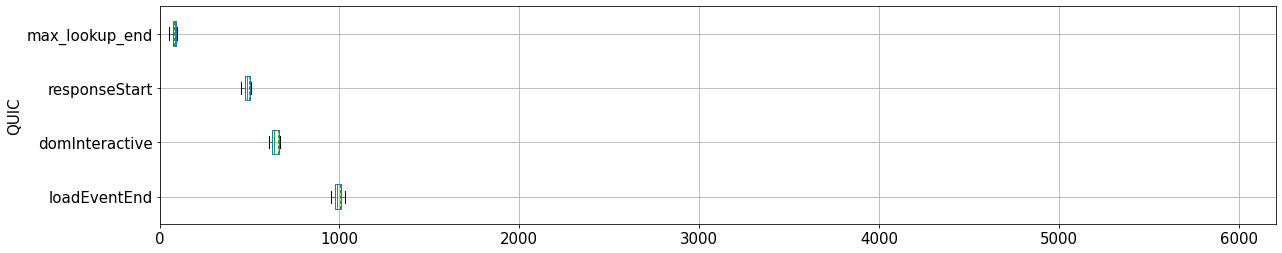

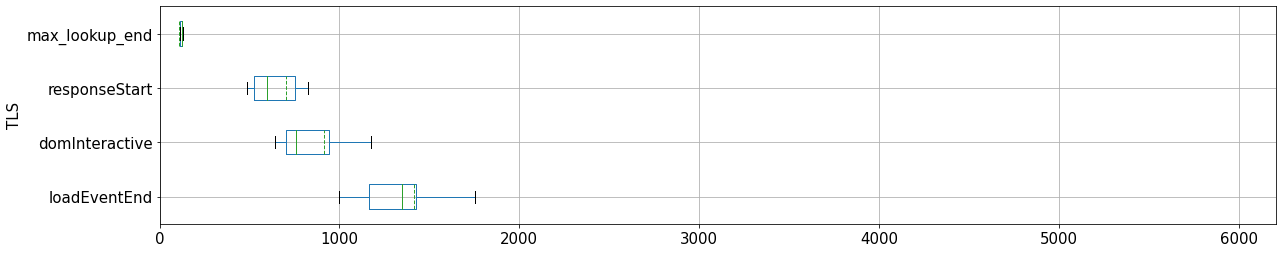

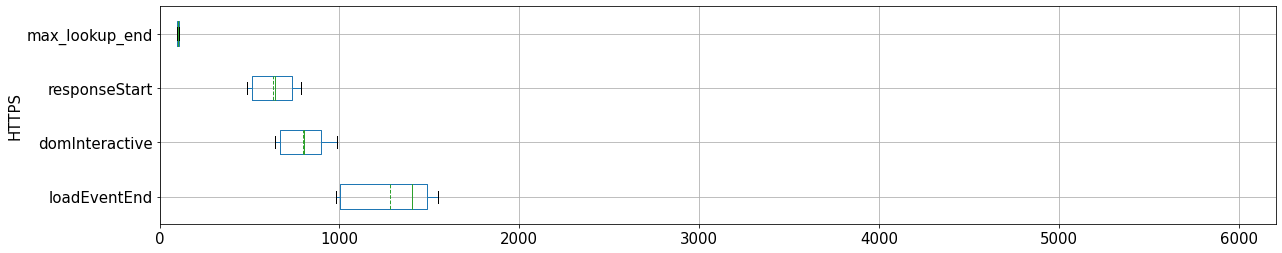

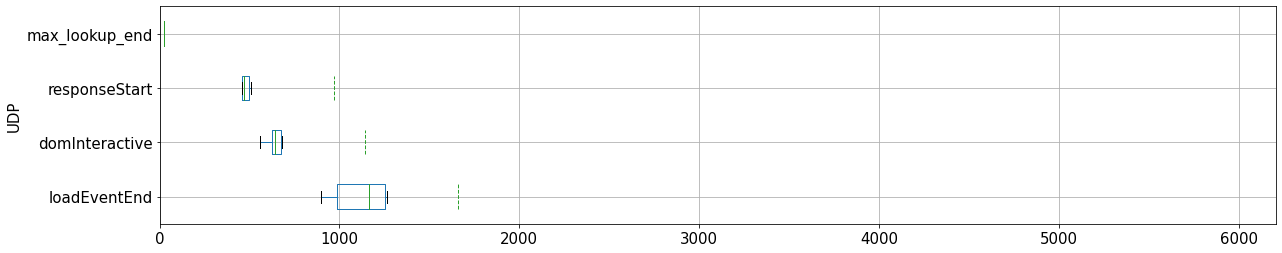

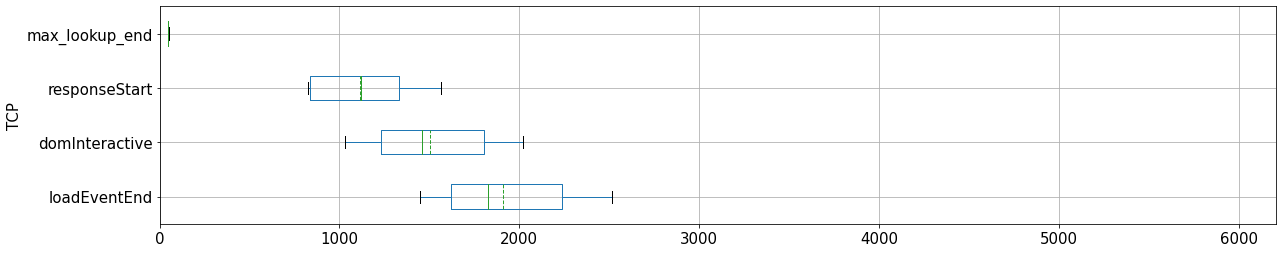

**youtube.com**

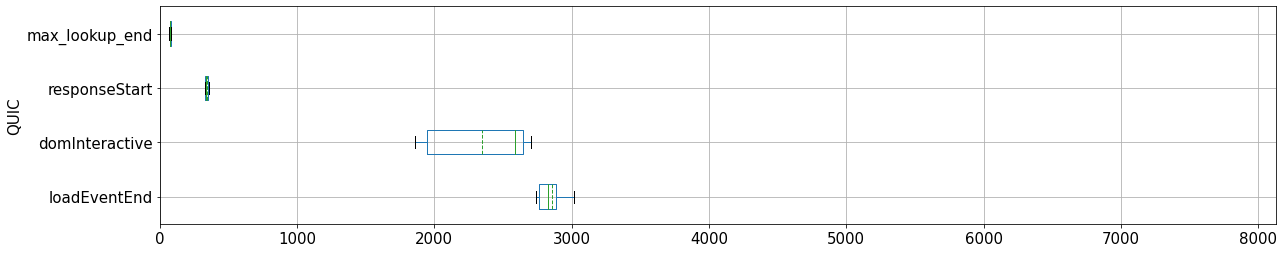

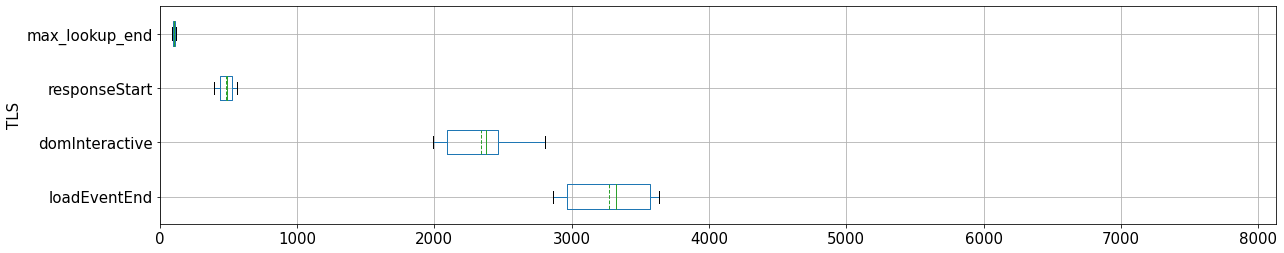

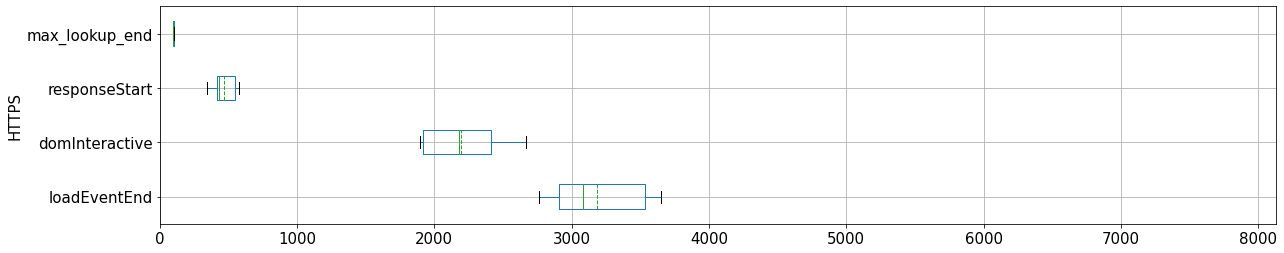

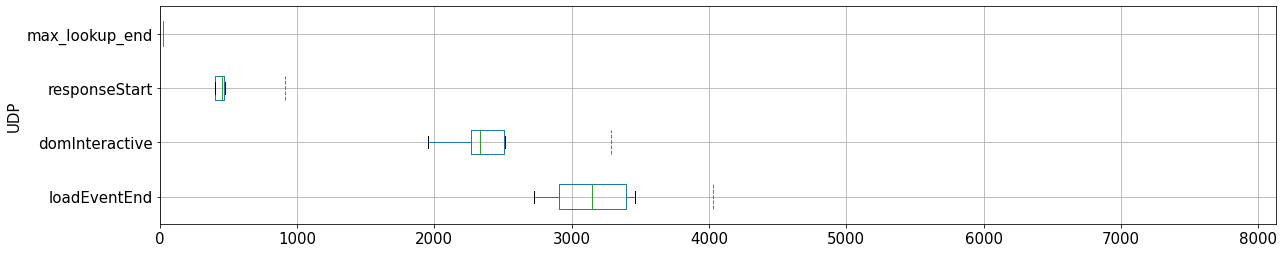

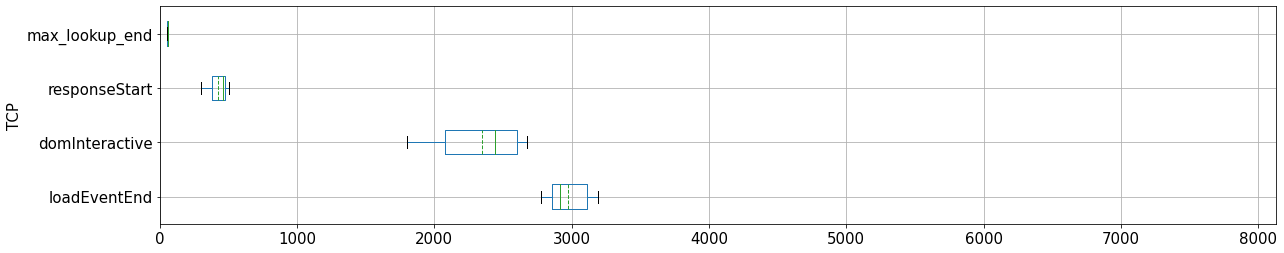

**facebook.com**

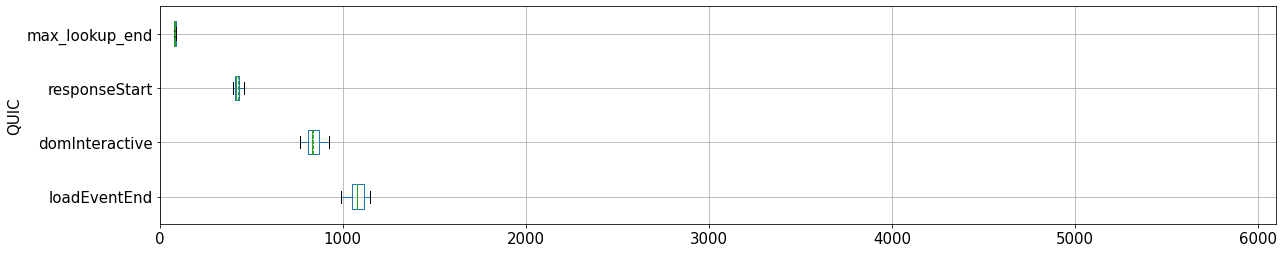

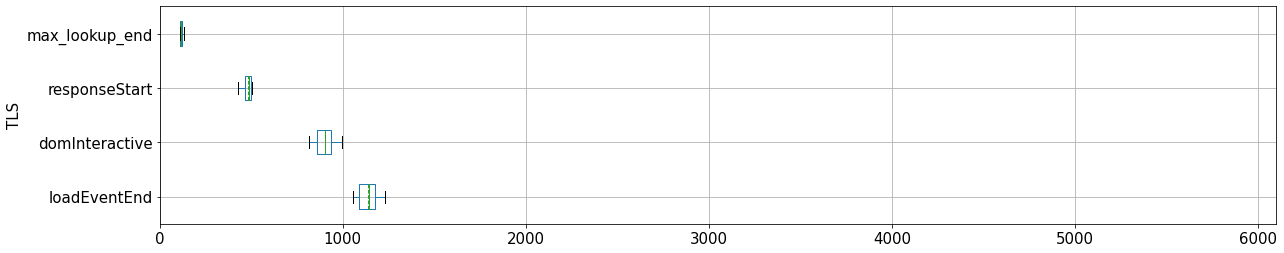

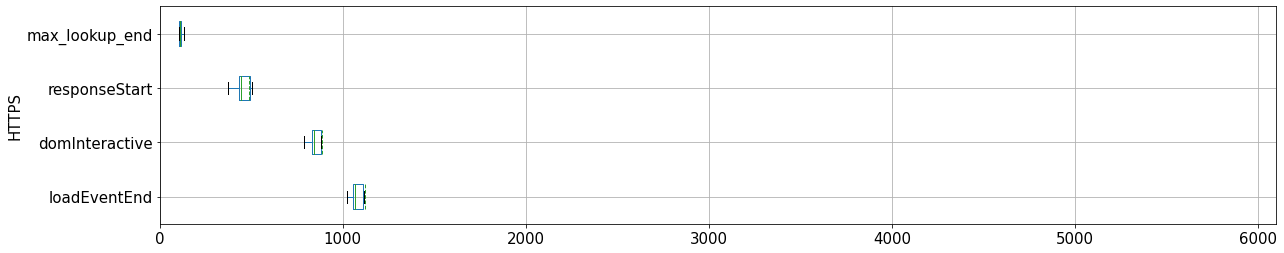

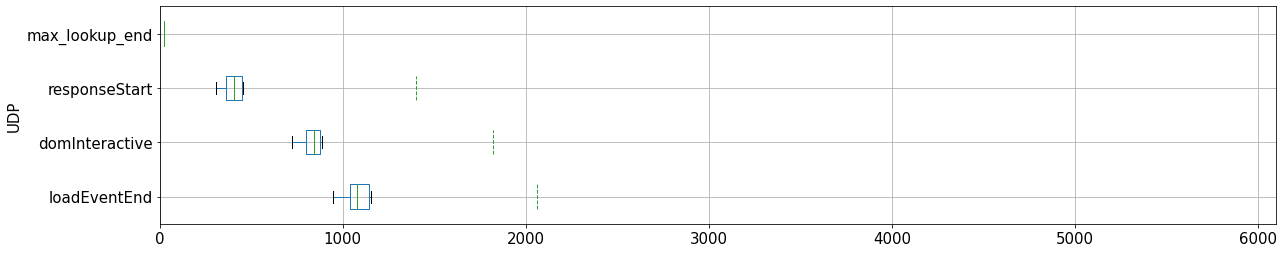

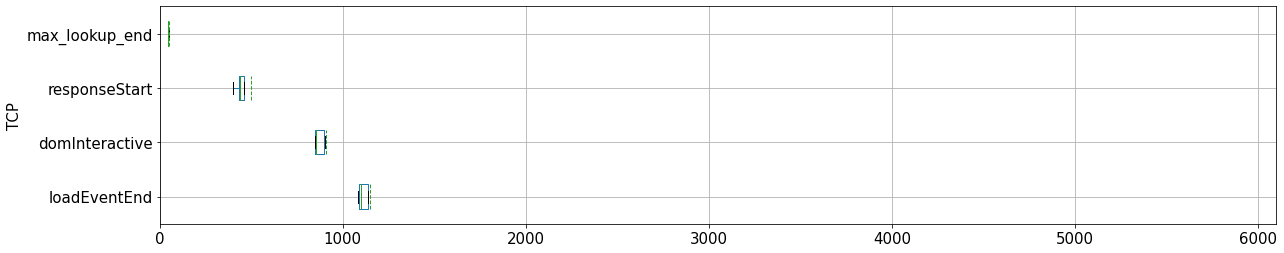

**netflix.com**

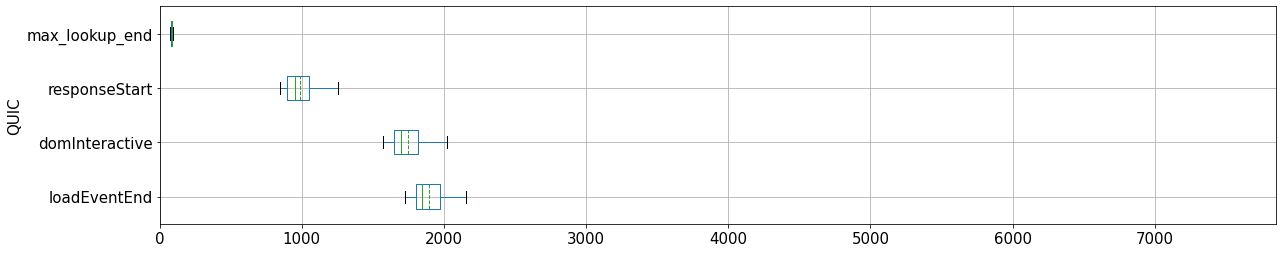

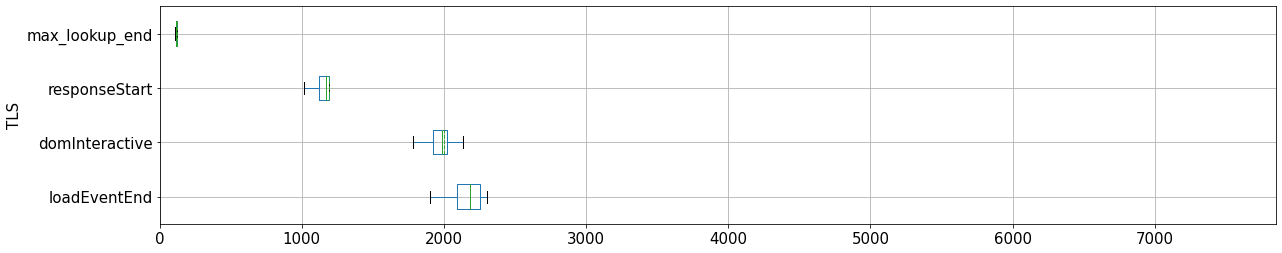

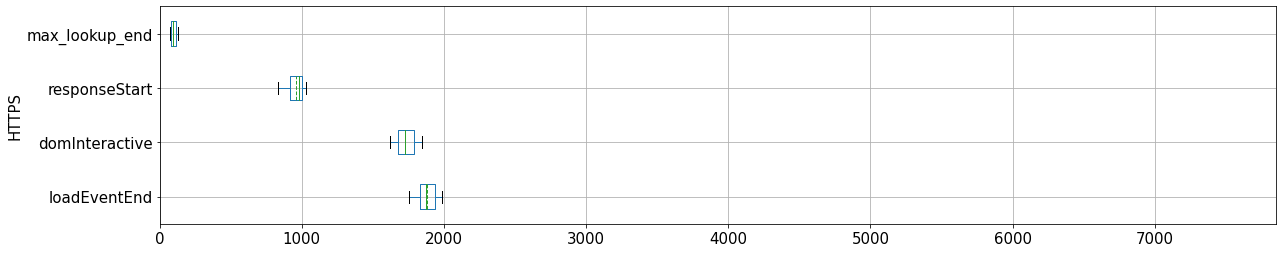

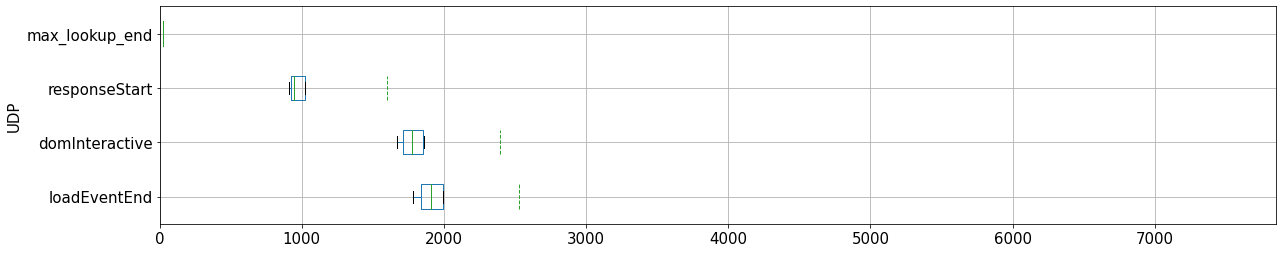

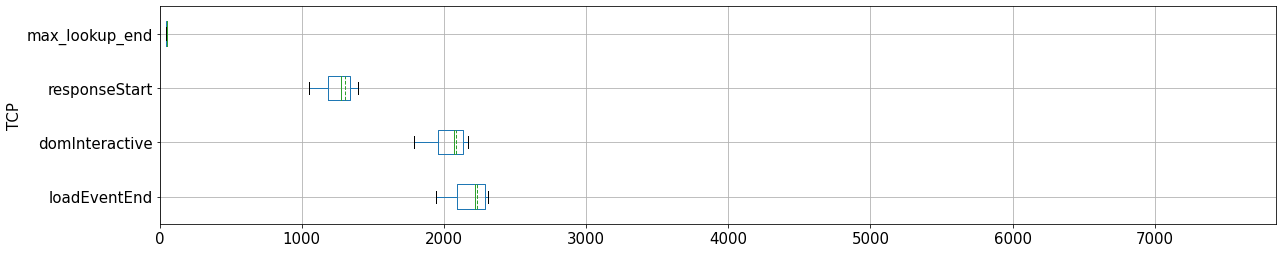

**microsoft.com**

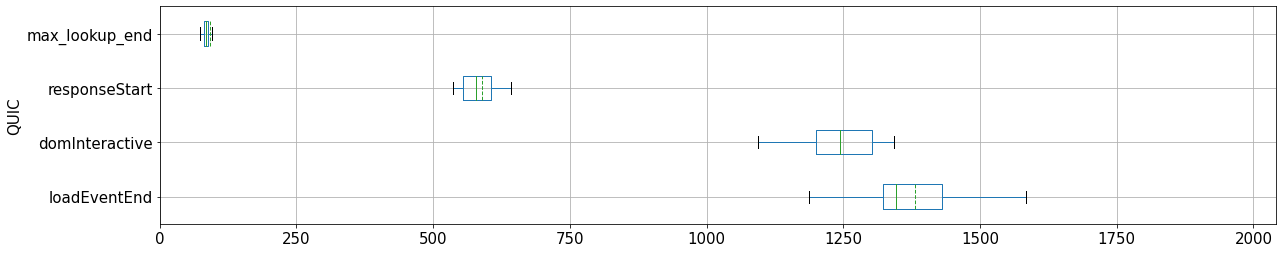

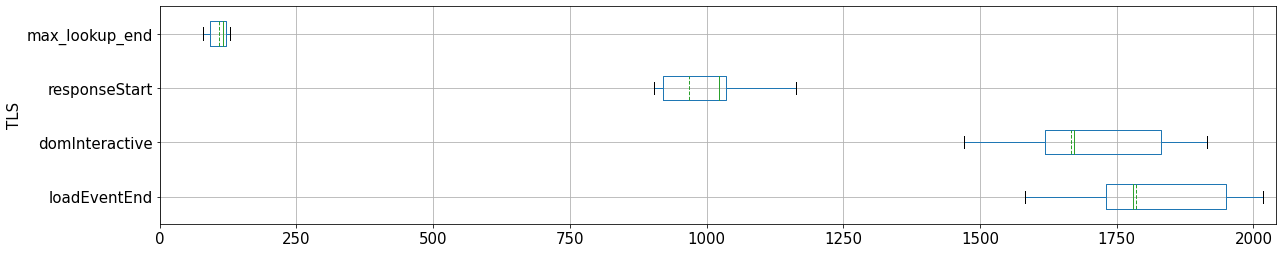

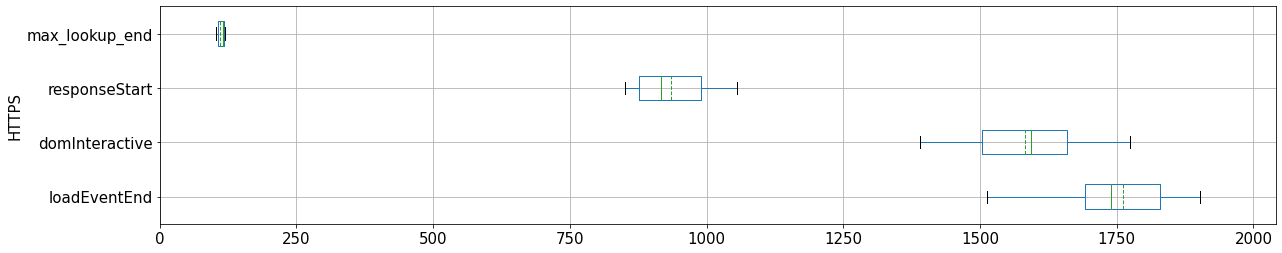

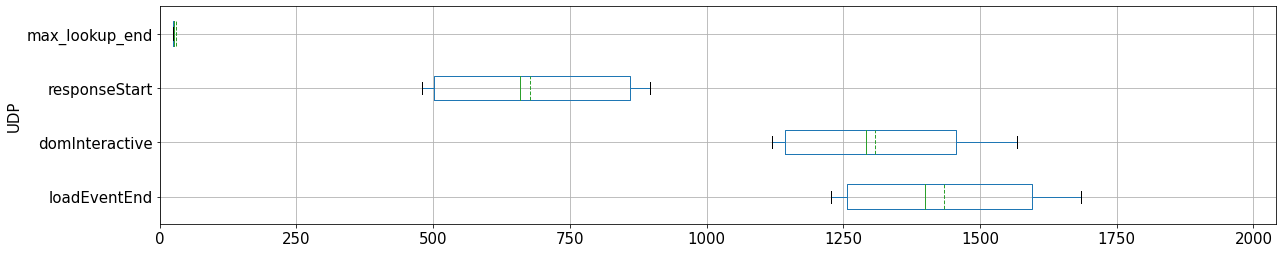

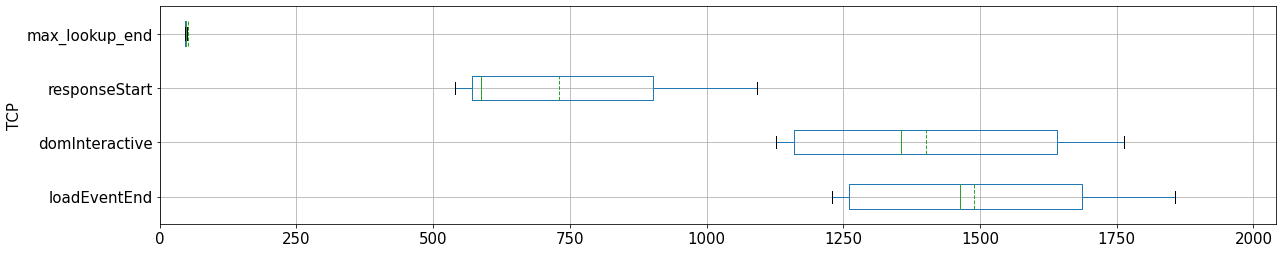

**twitter.com**

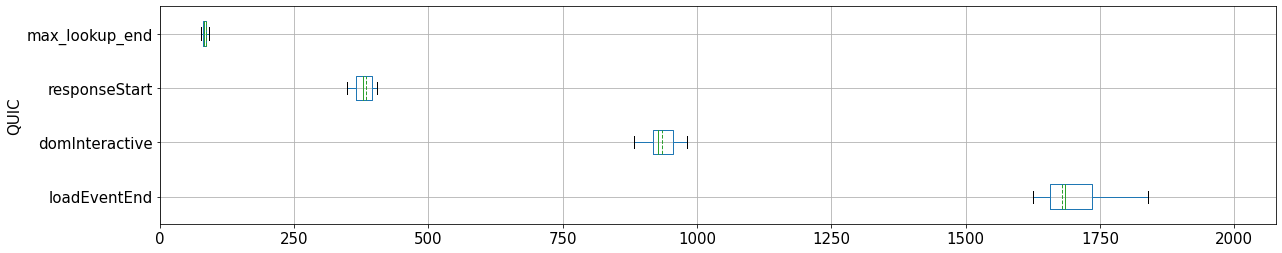

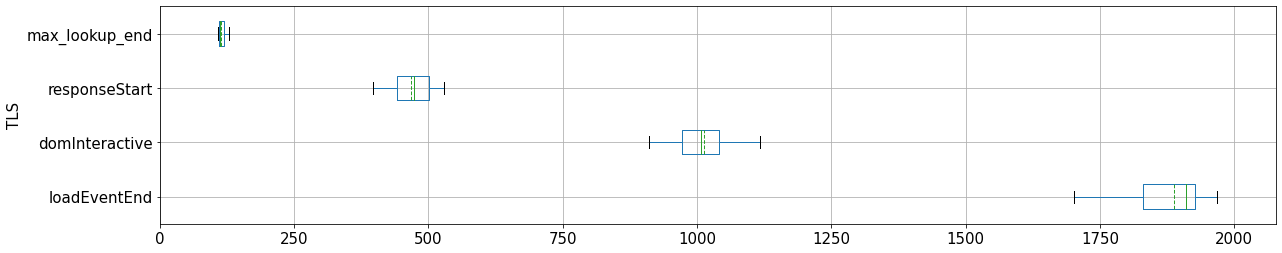

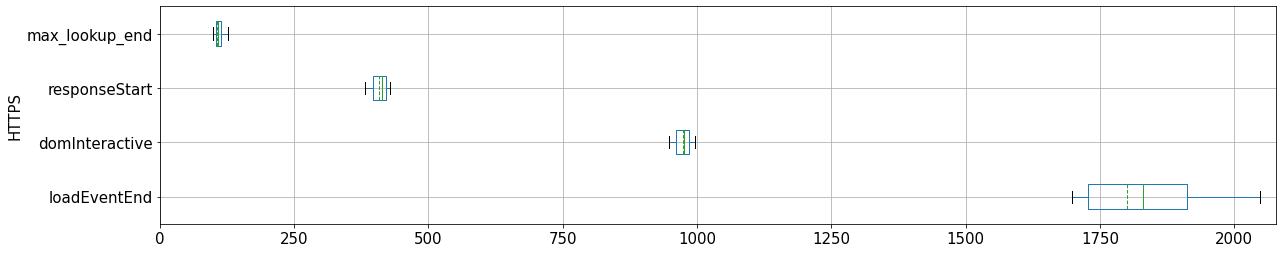

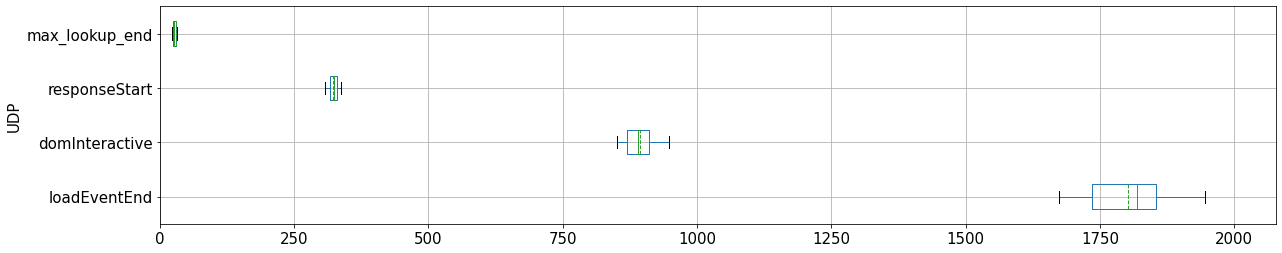

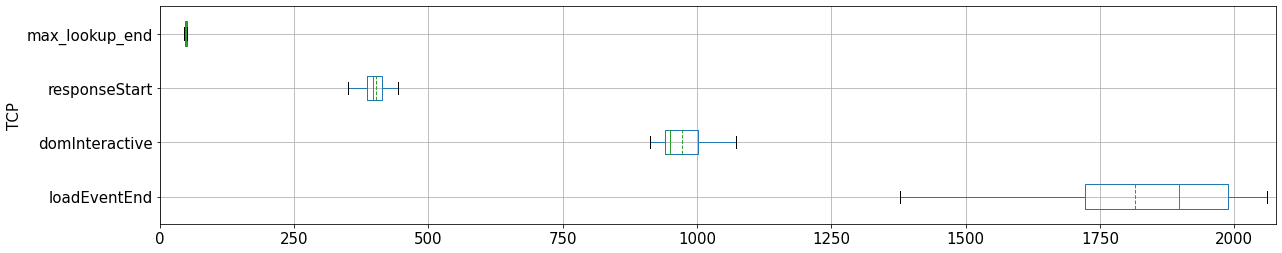

**instagram.com**

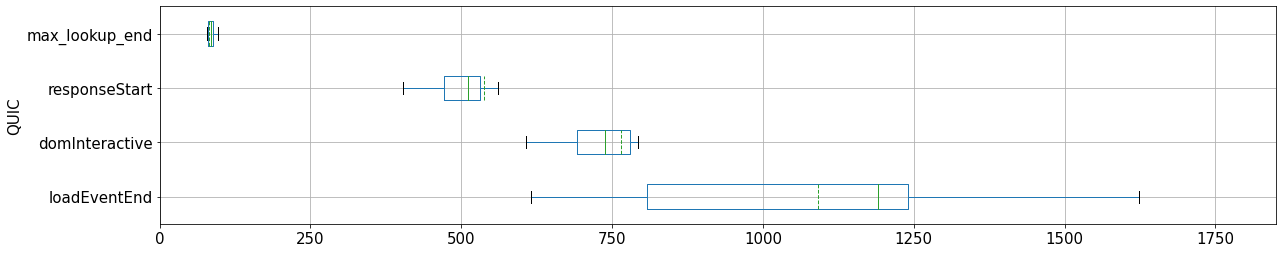

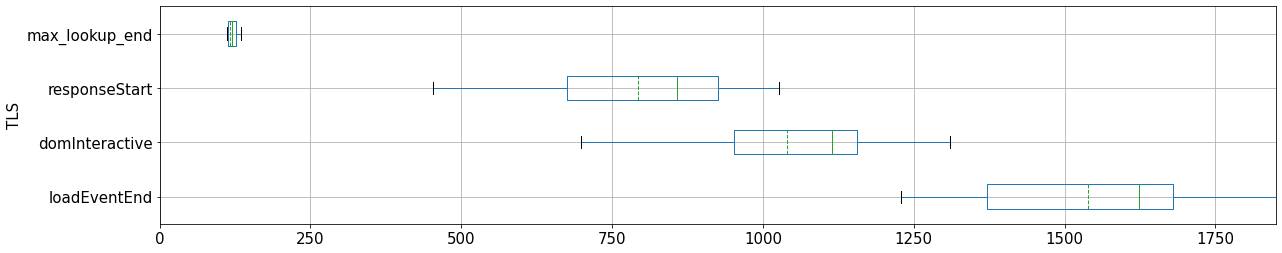

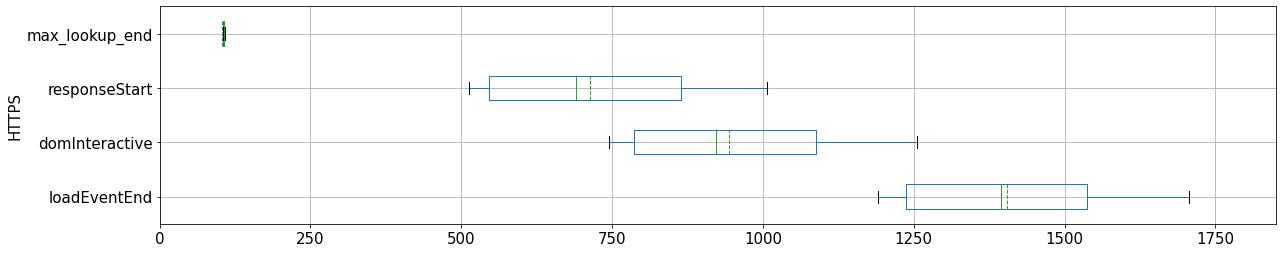

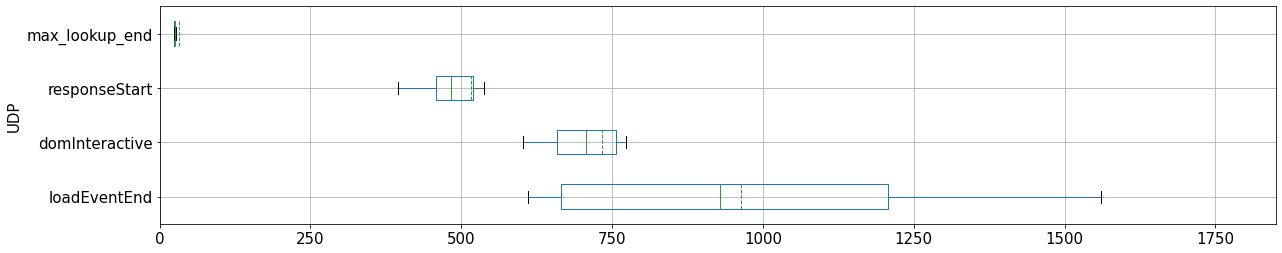

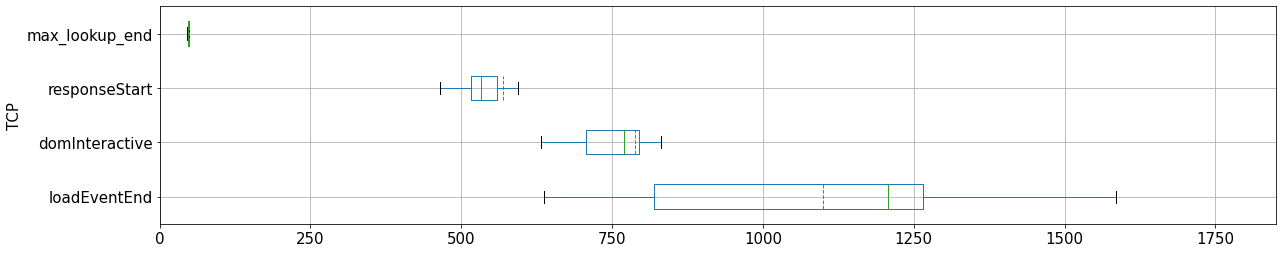

**tmall.com**

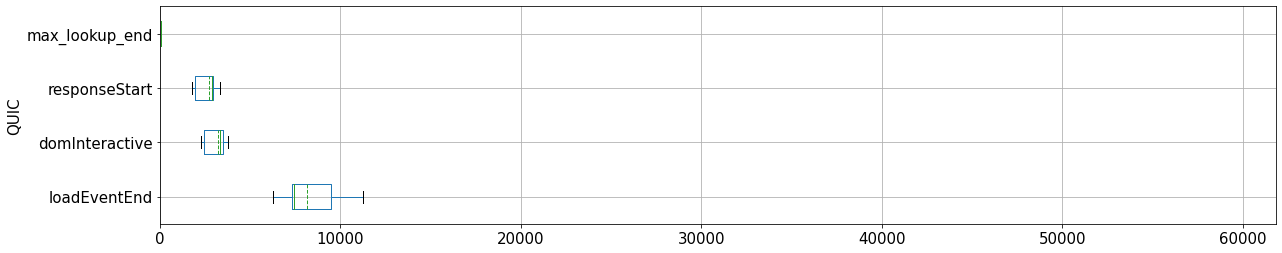

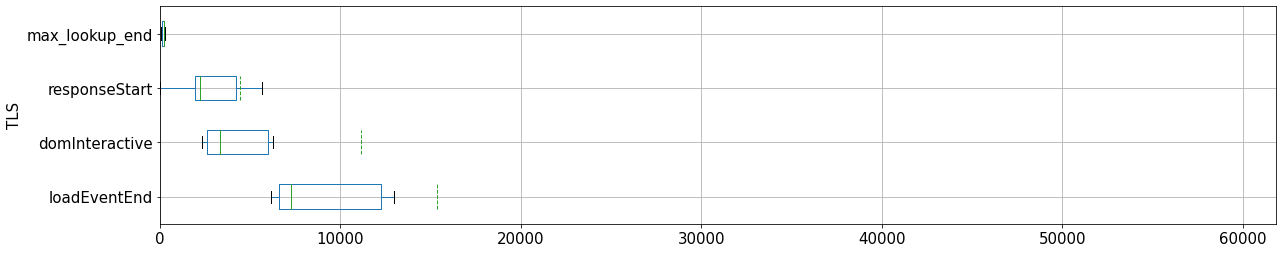

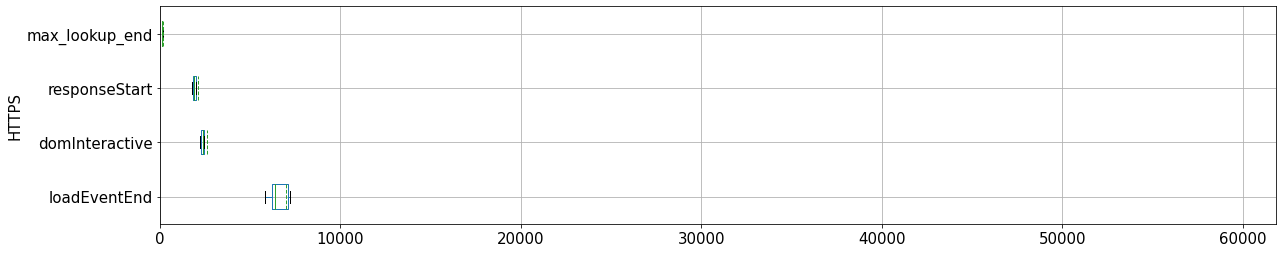

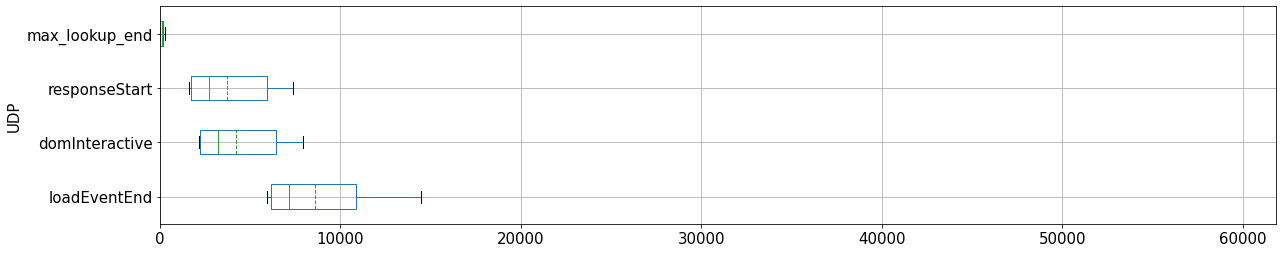

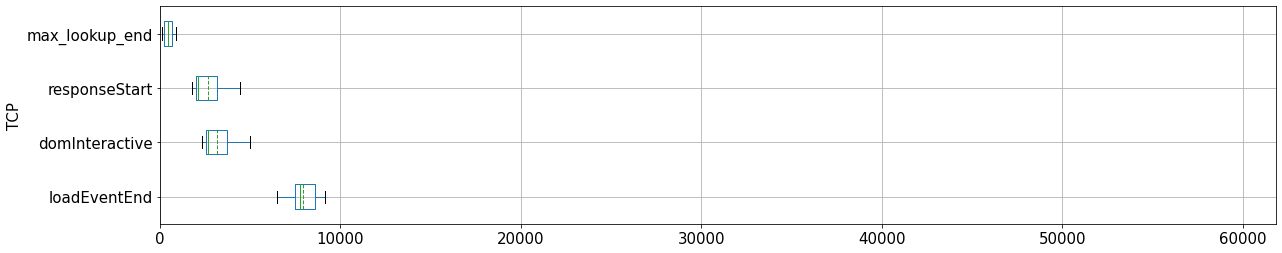

**linkedin.com**

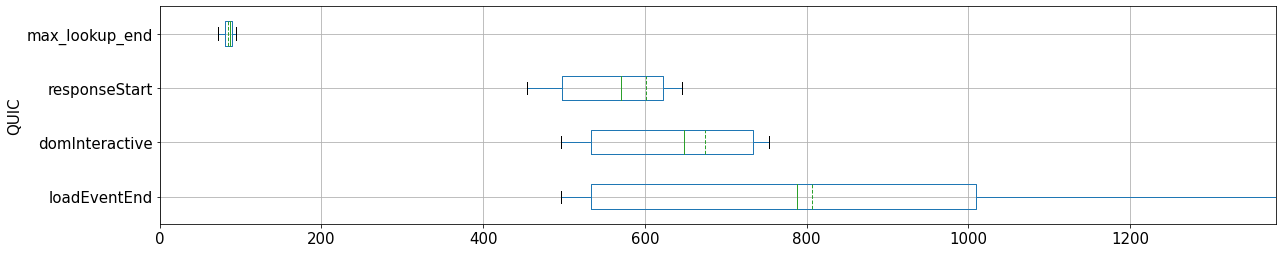

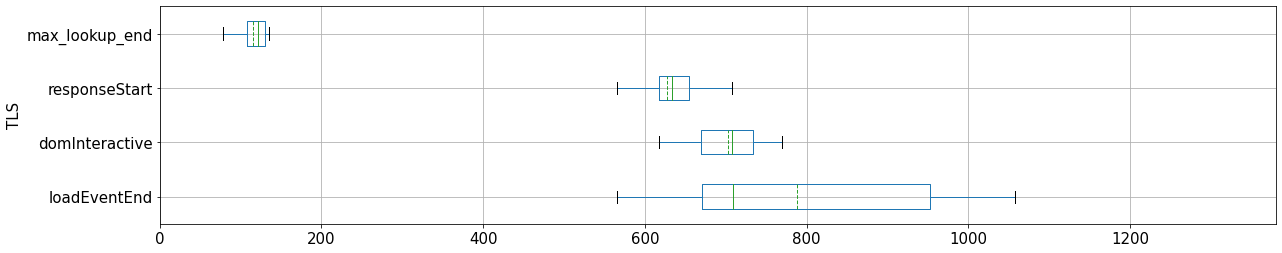

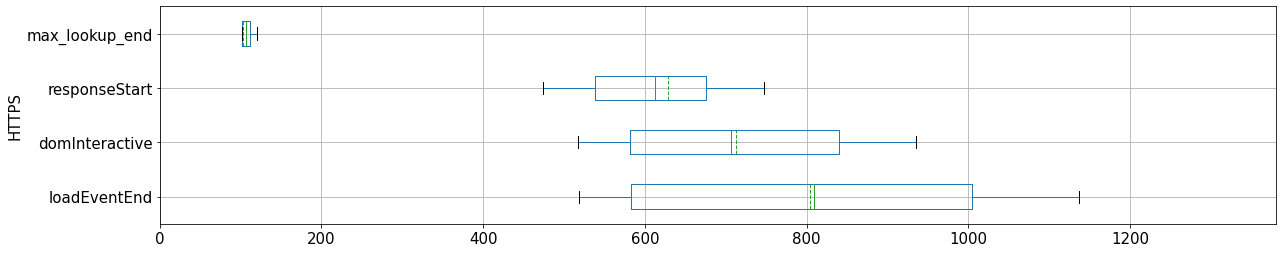

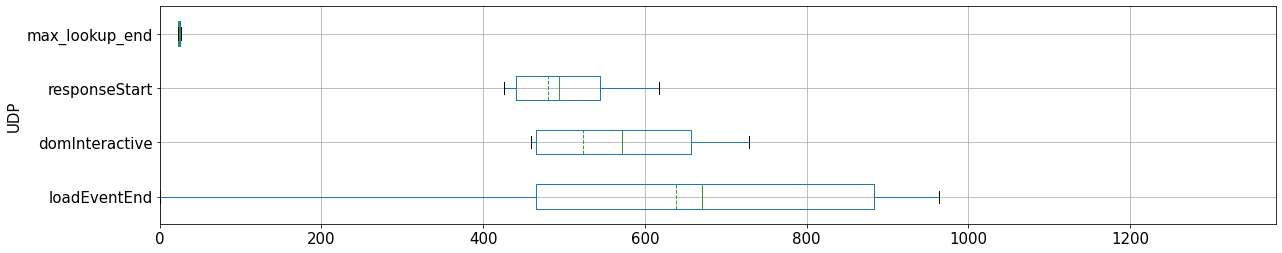

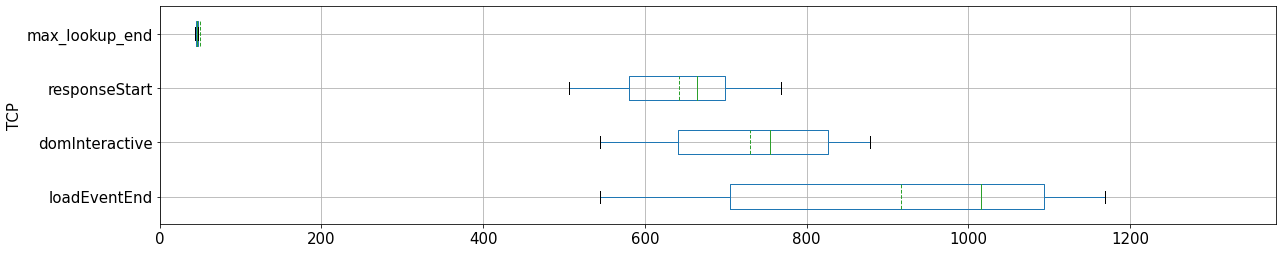

**apple.com**

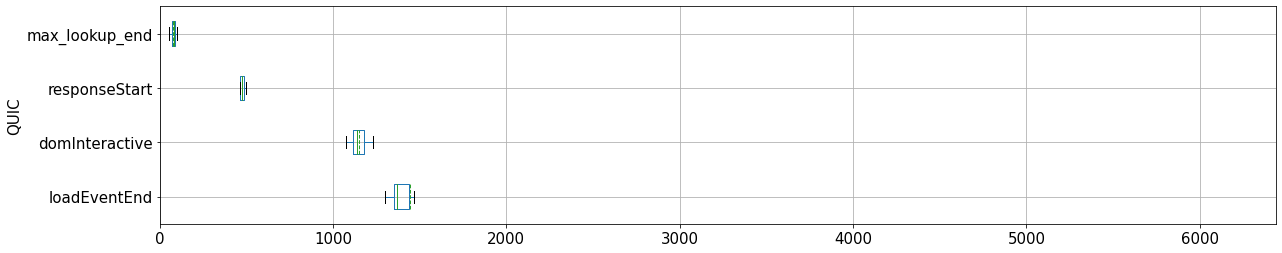

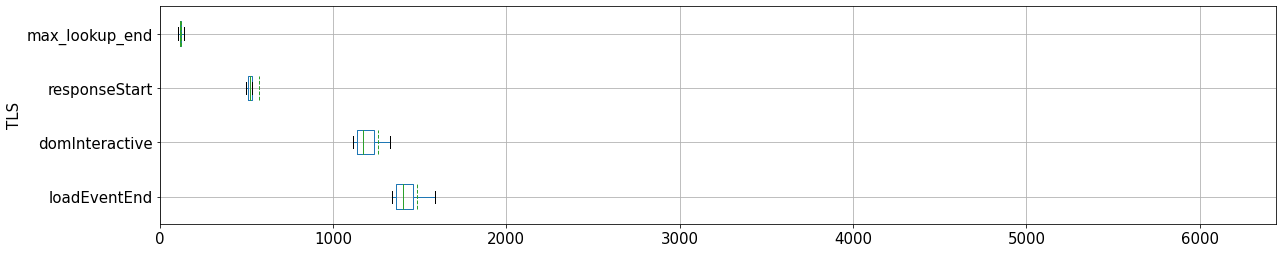

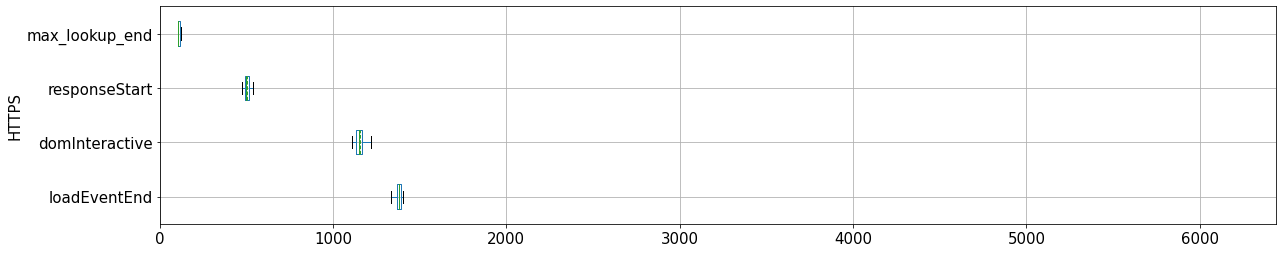

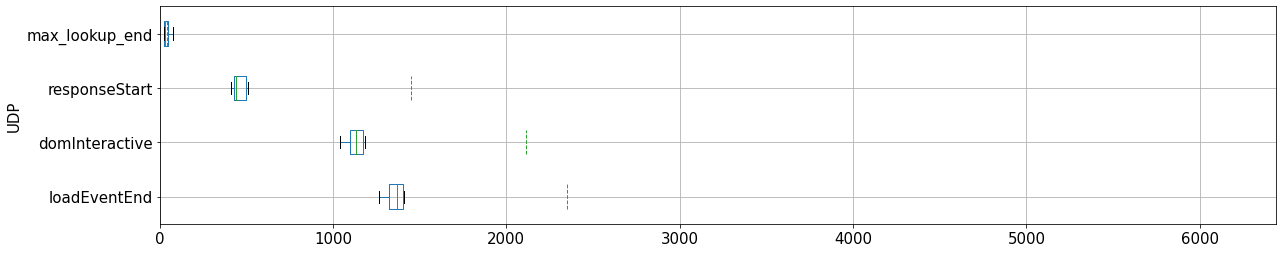

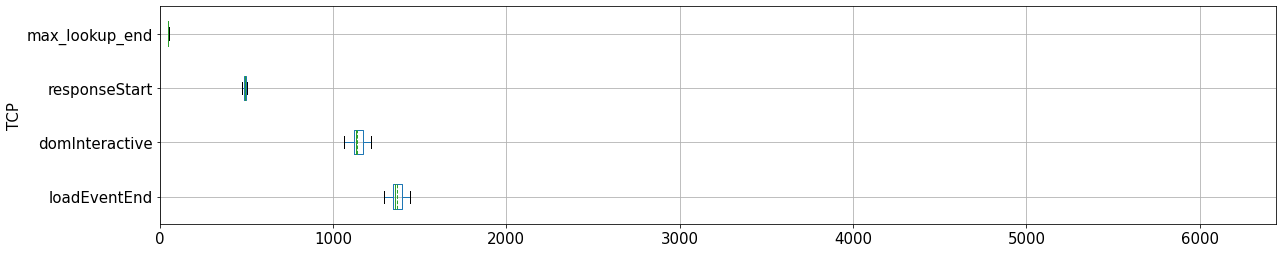

**qq.com**

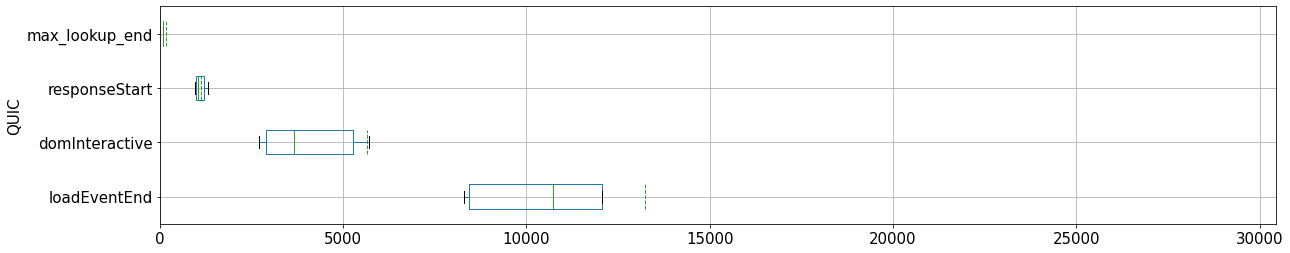

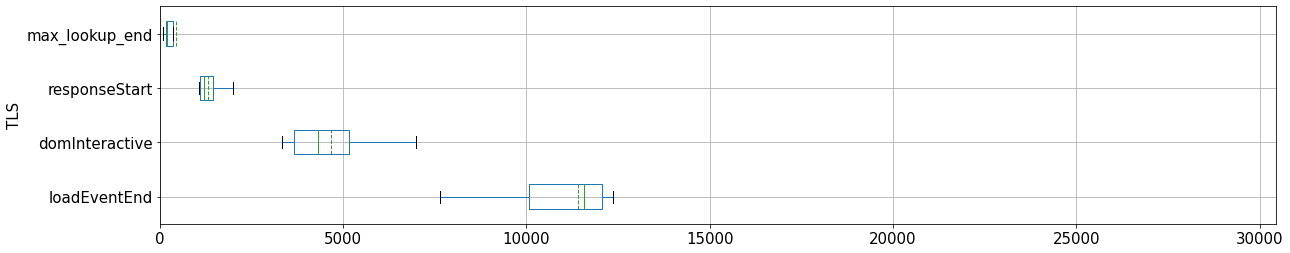

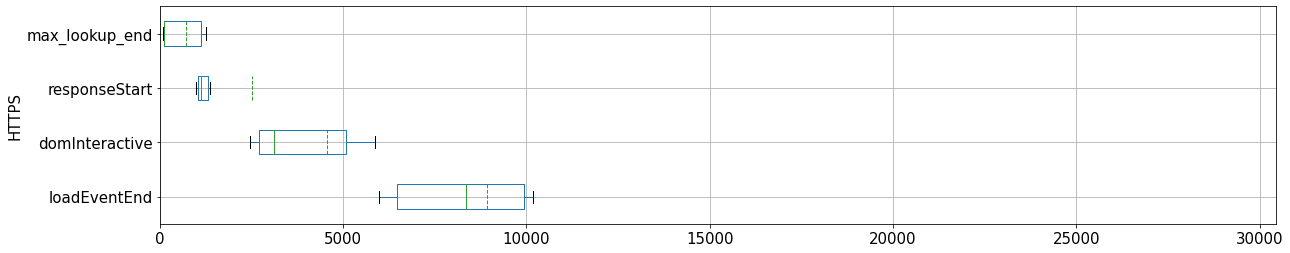

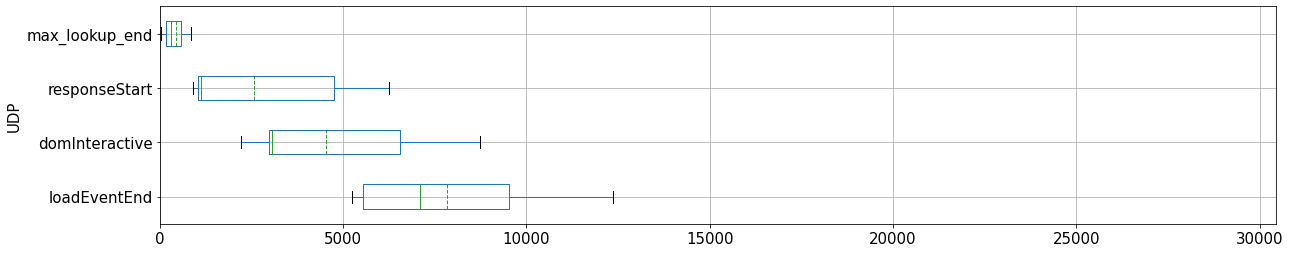

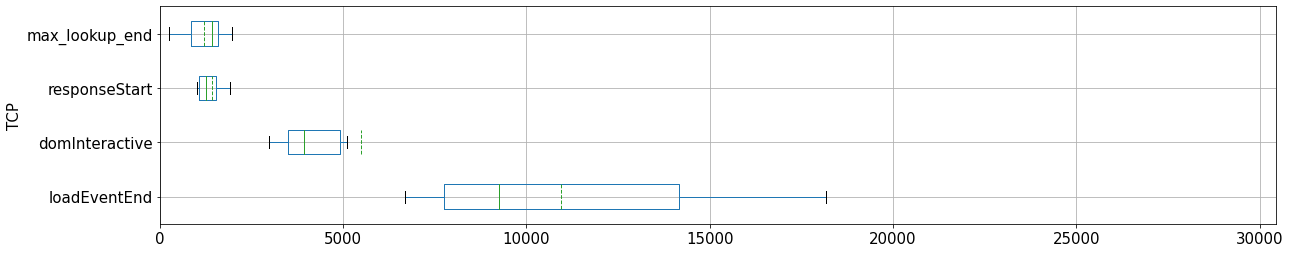

**wikipedia.org**

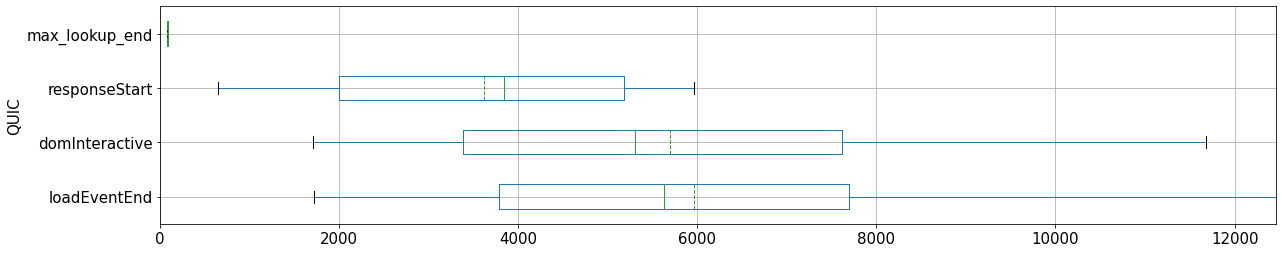

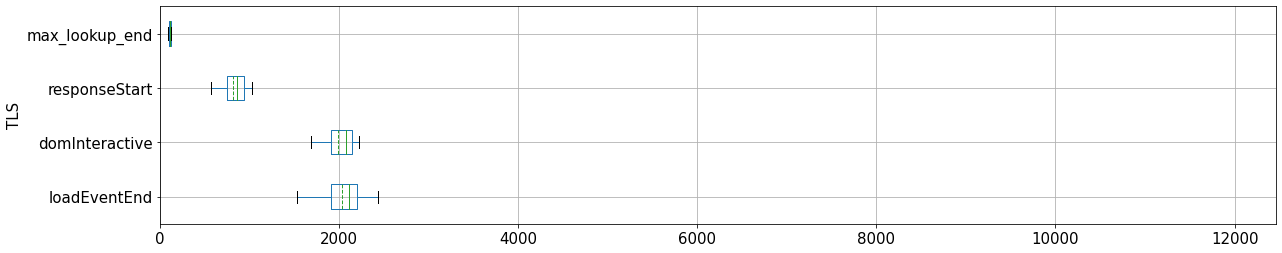

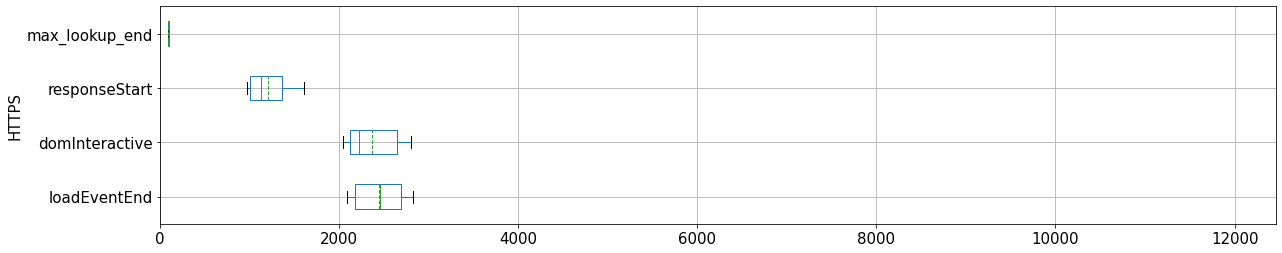

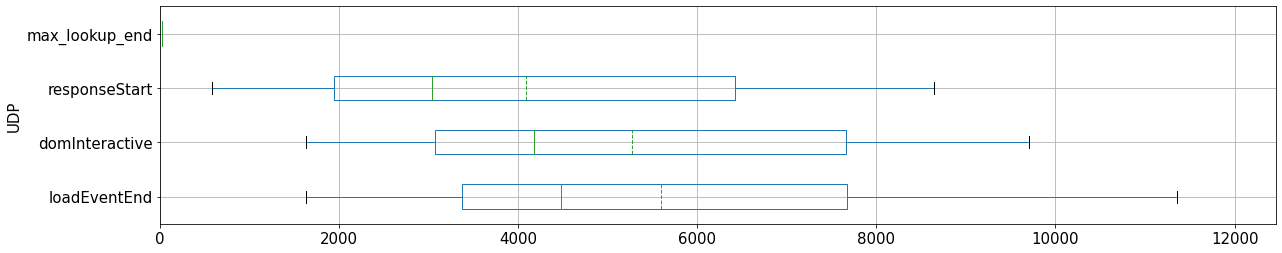

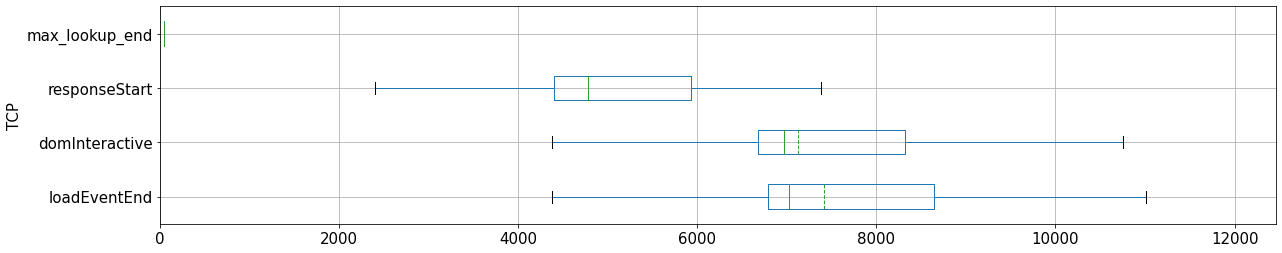

**baidu.com**

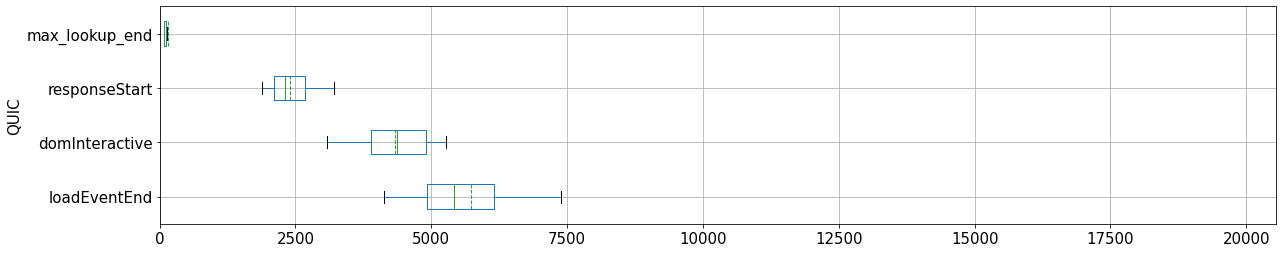

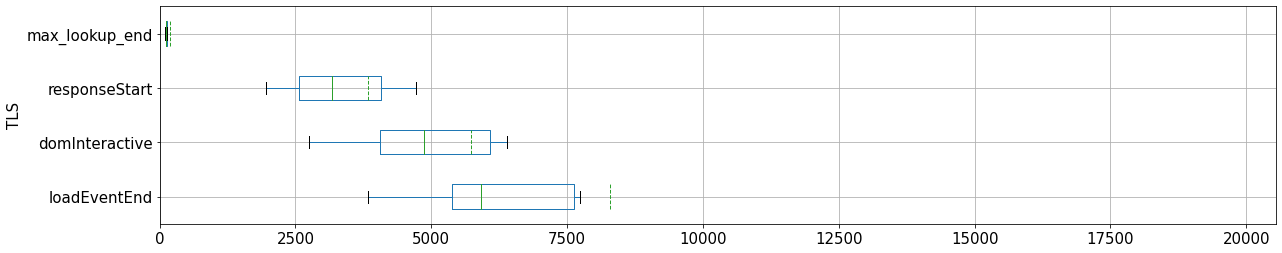

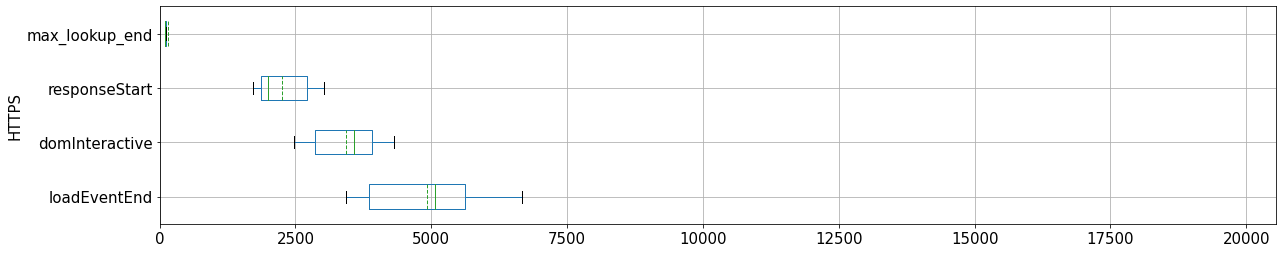

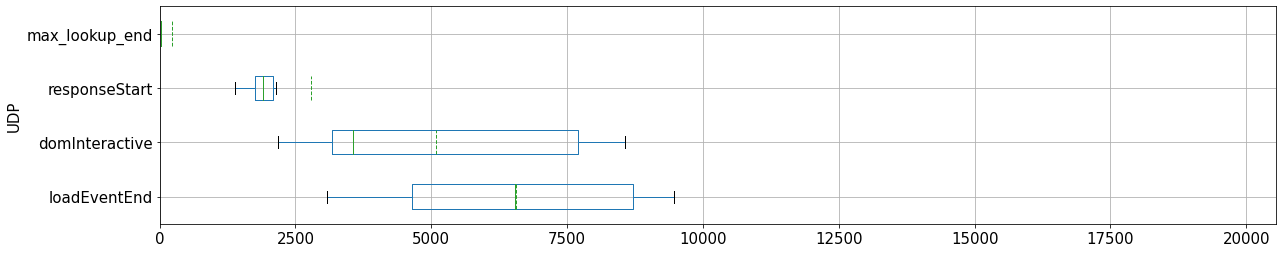

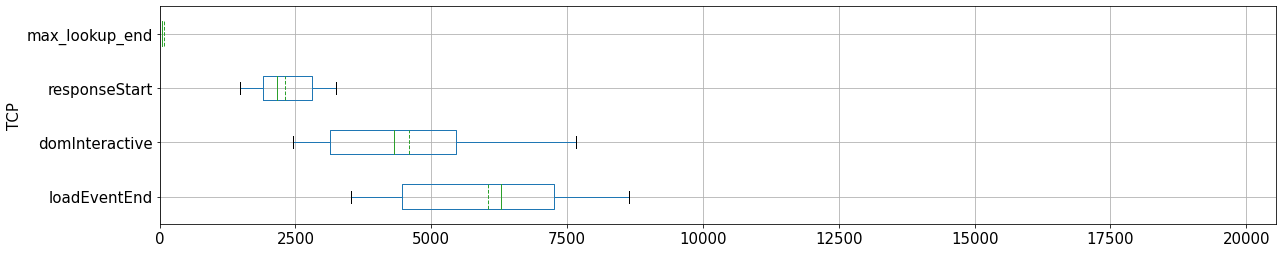

**sohu.com**

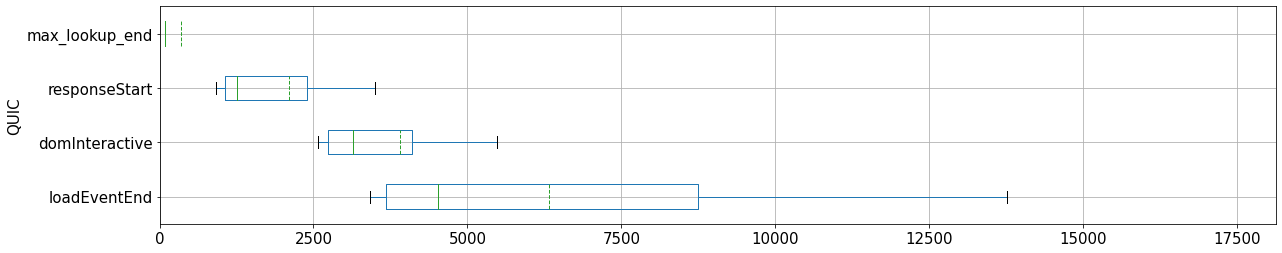

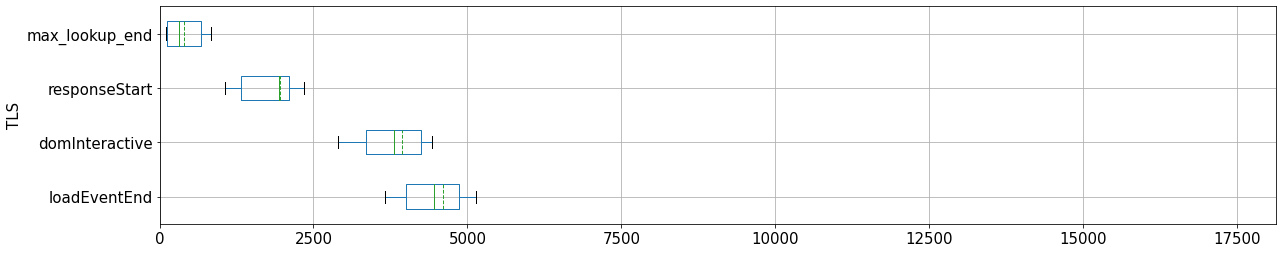

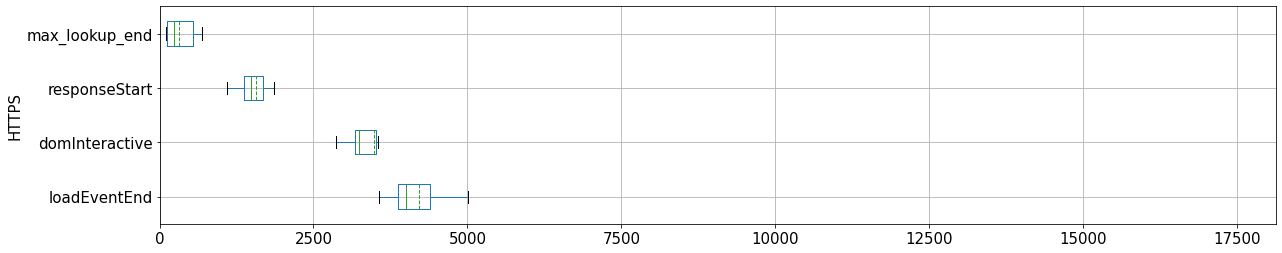

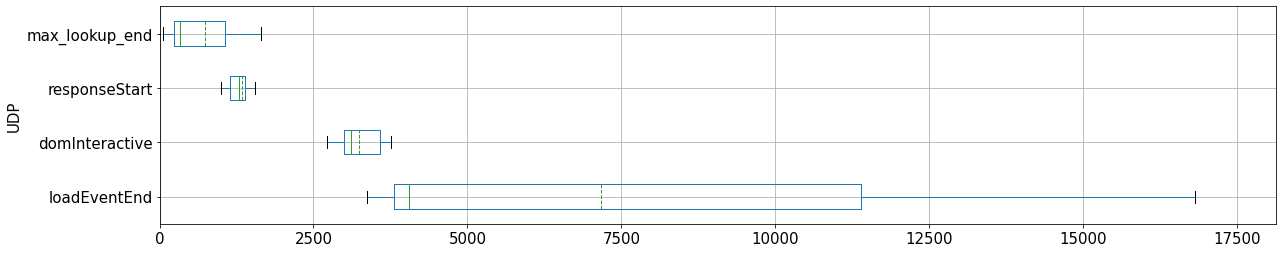

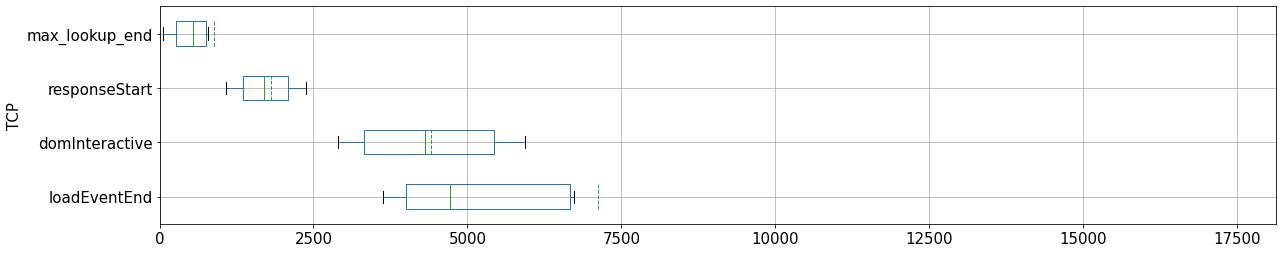

**googletagmanager.com**

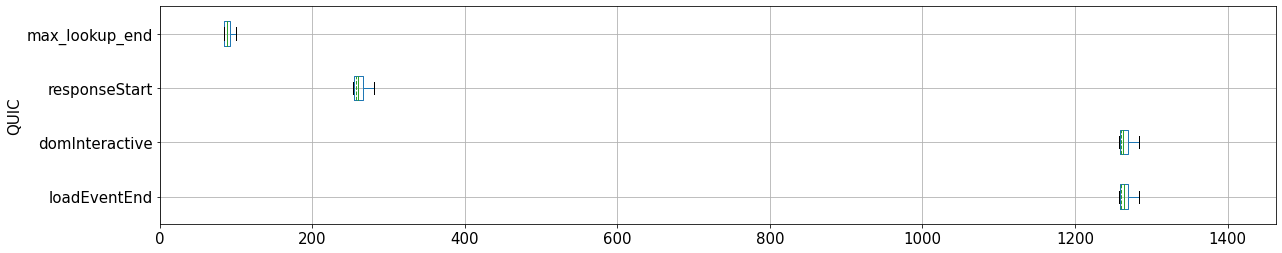

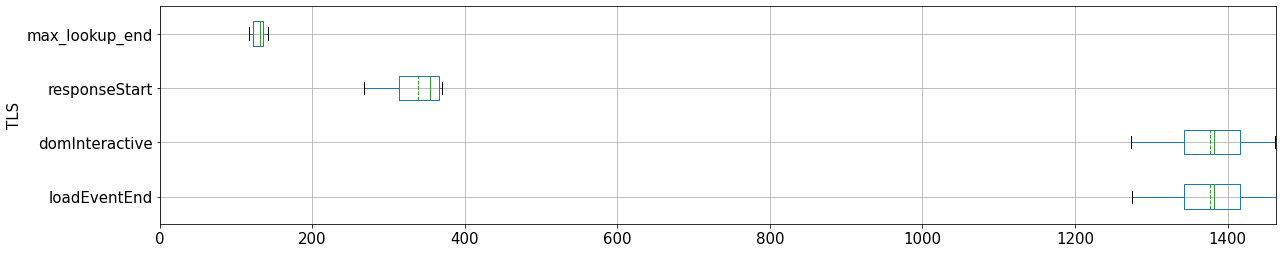

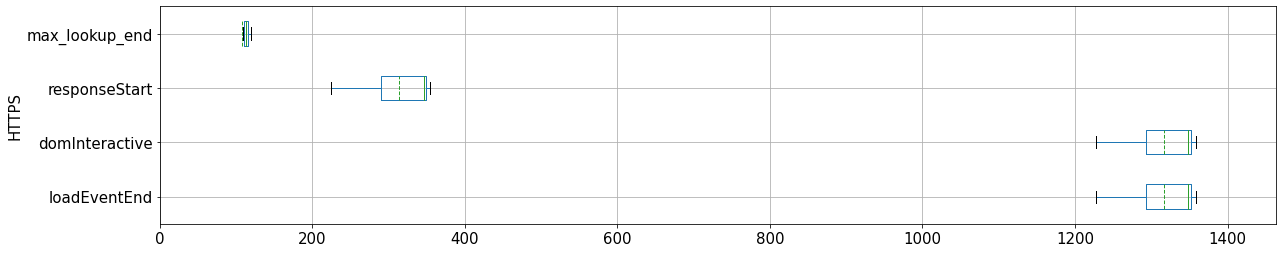

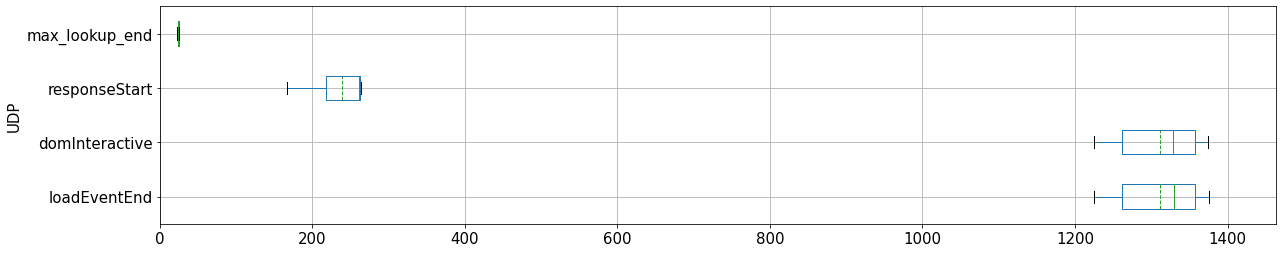

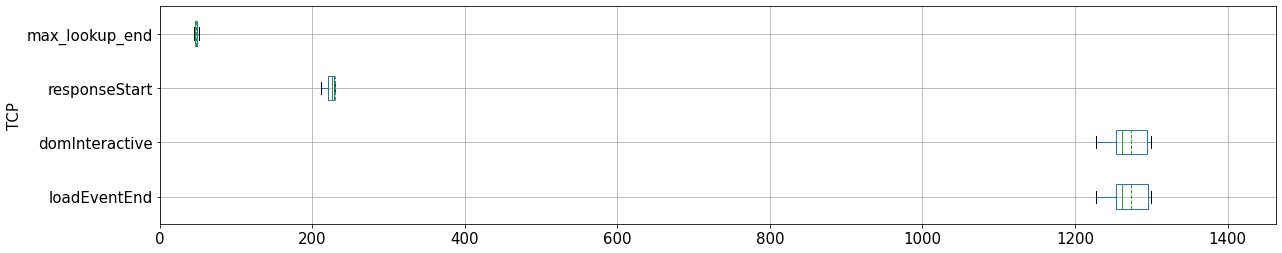

**wordpress.org**

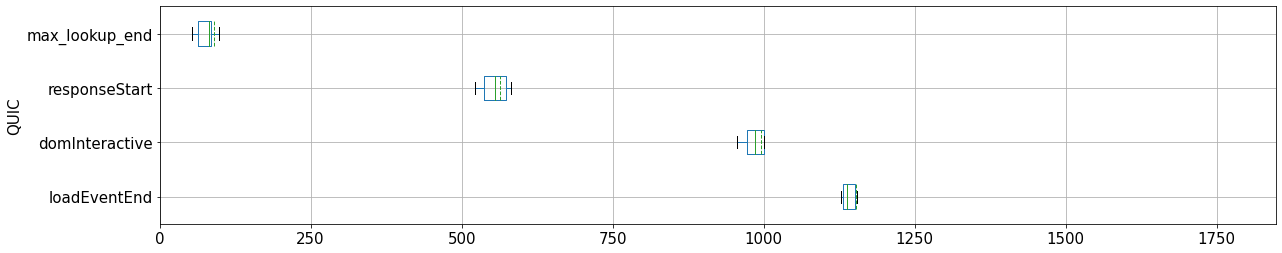

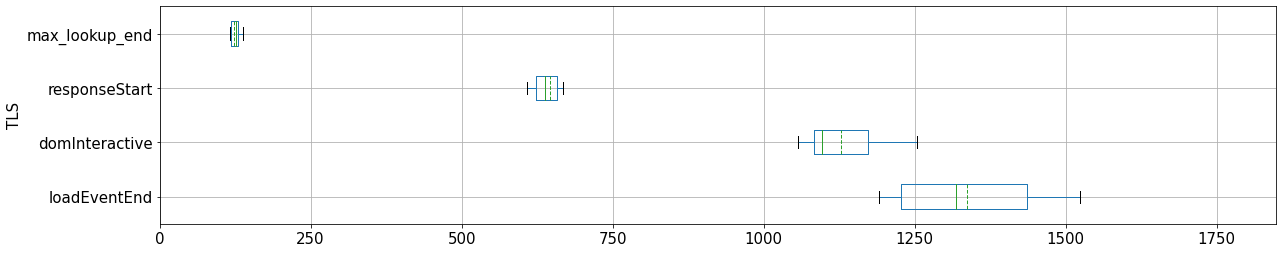

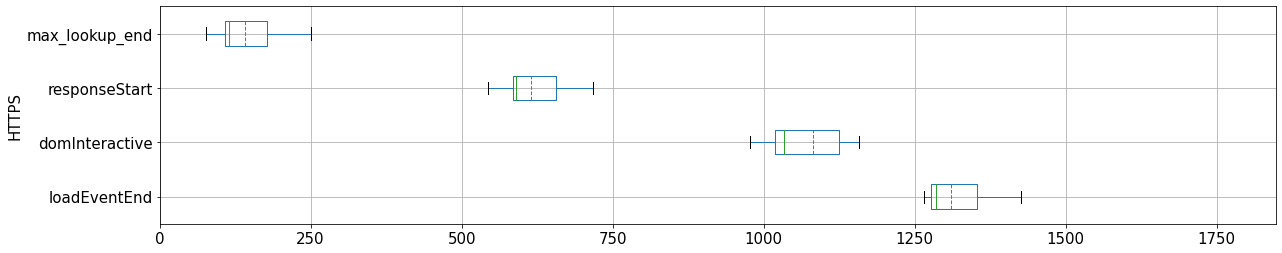

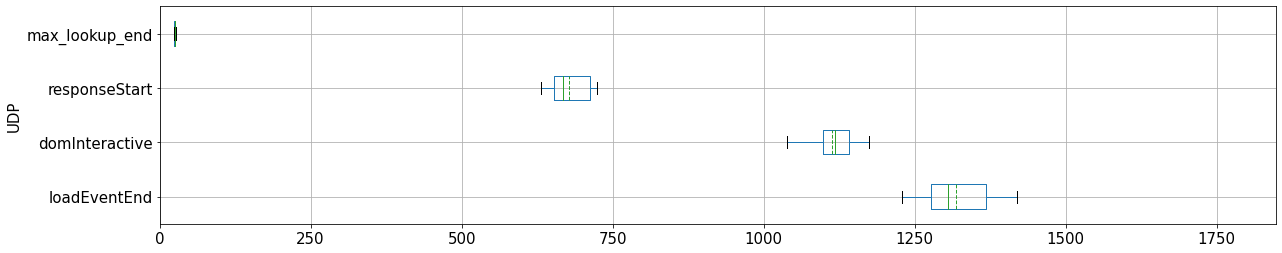

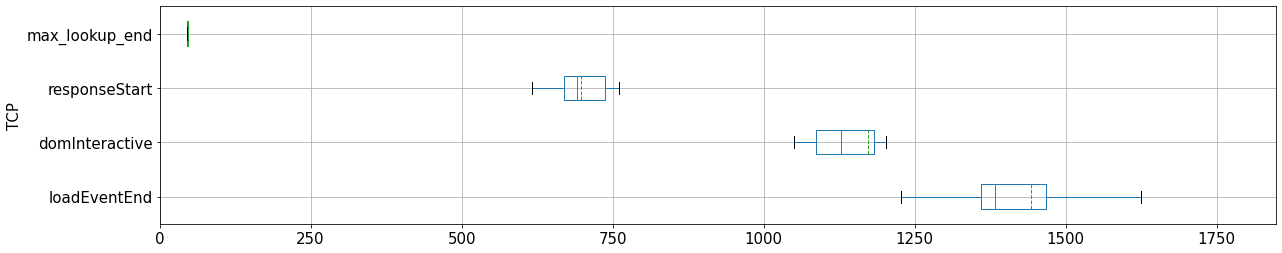

**live.com**

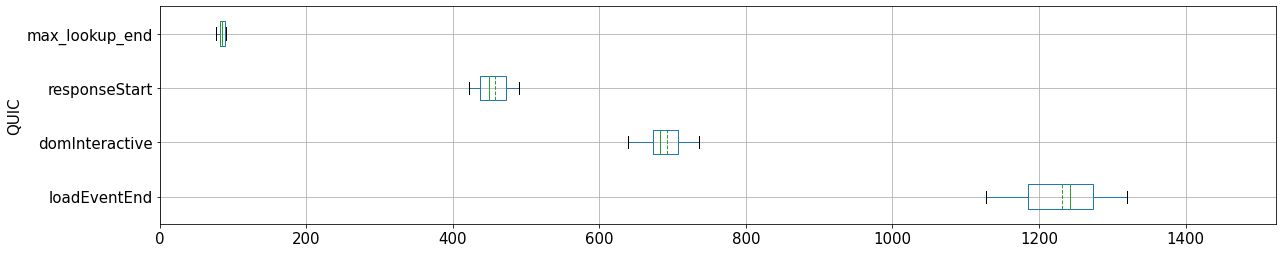

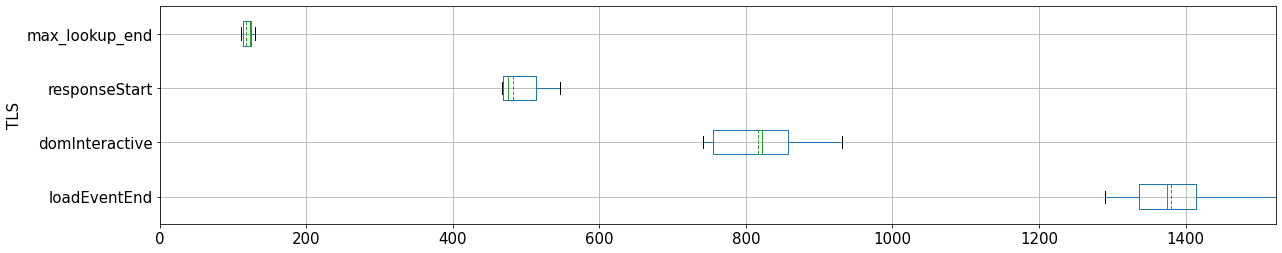

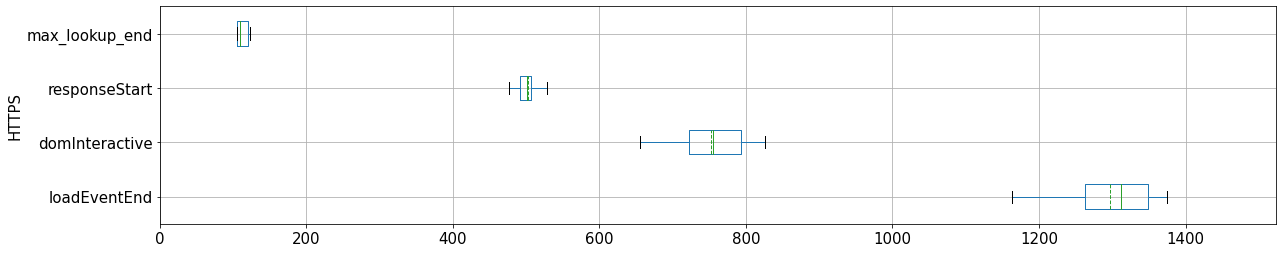

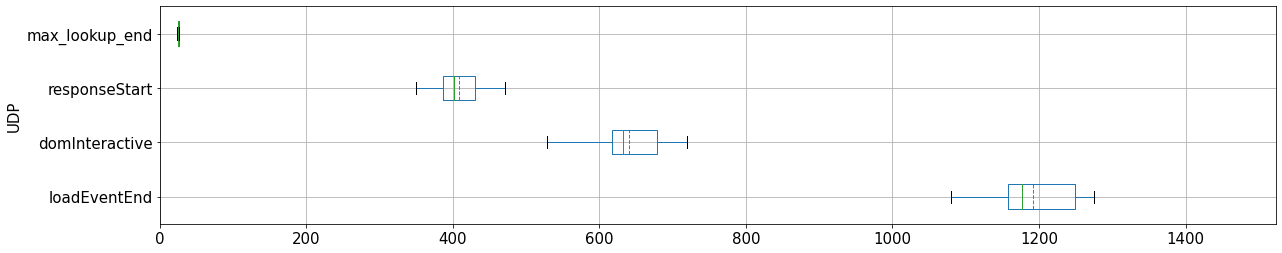

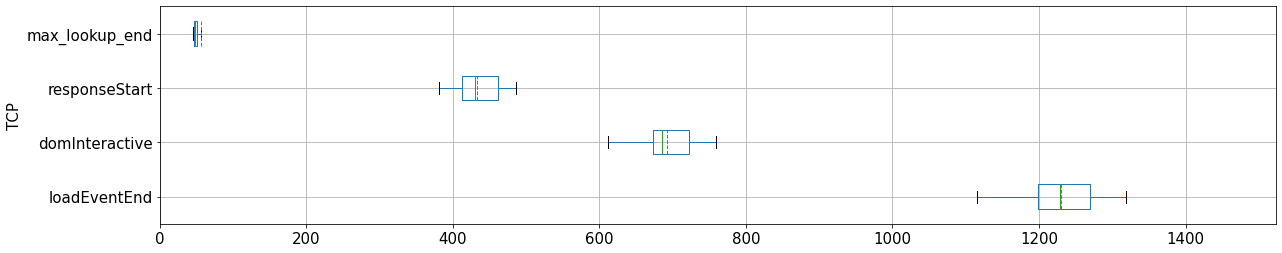

**yahoo.com**

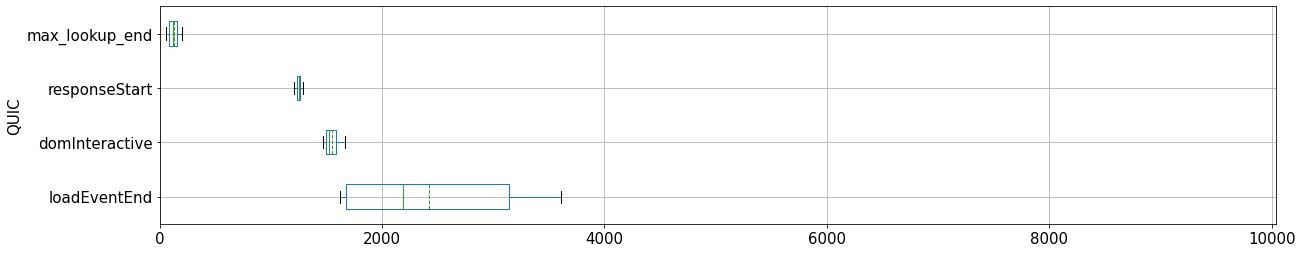

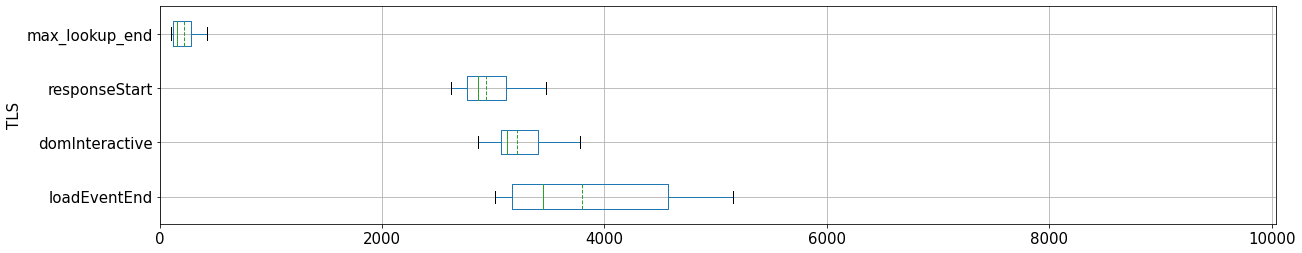

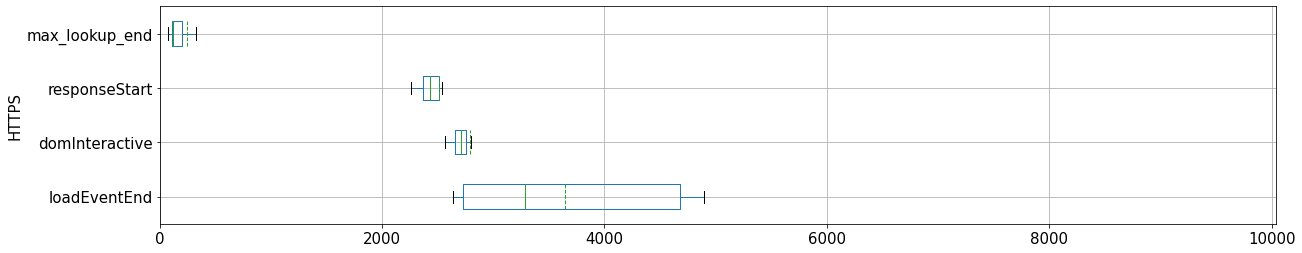

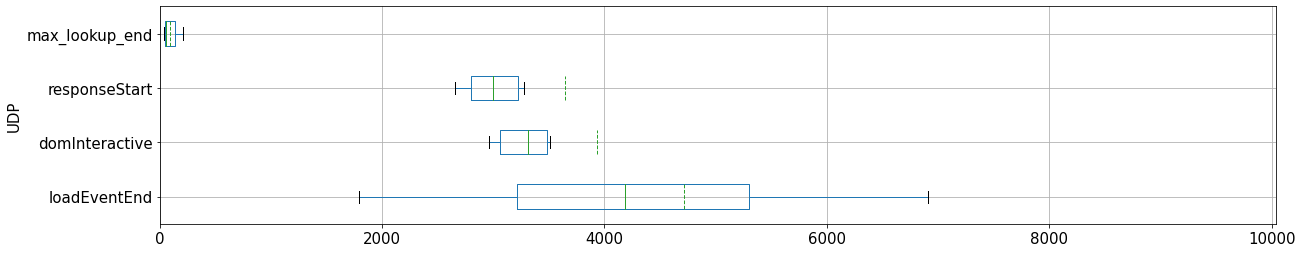

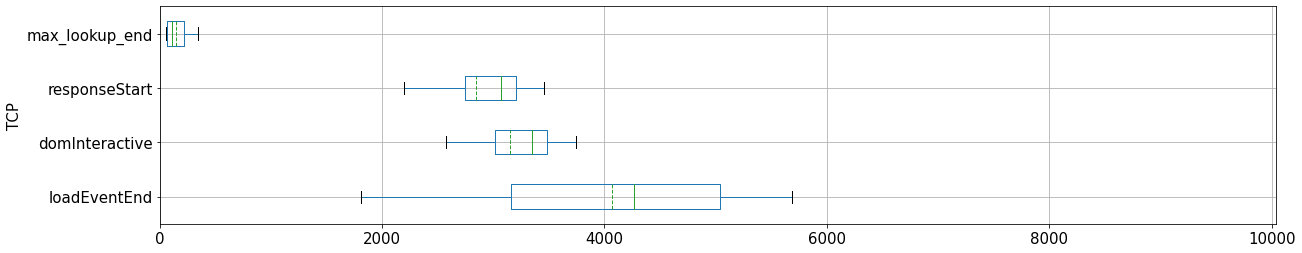

**amazon.com**

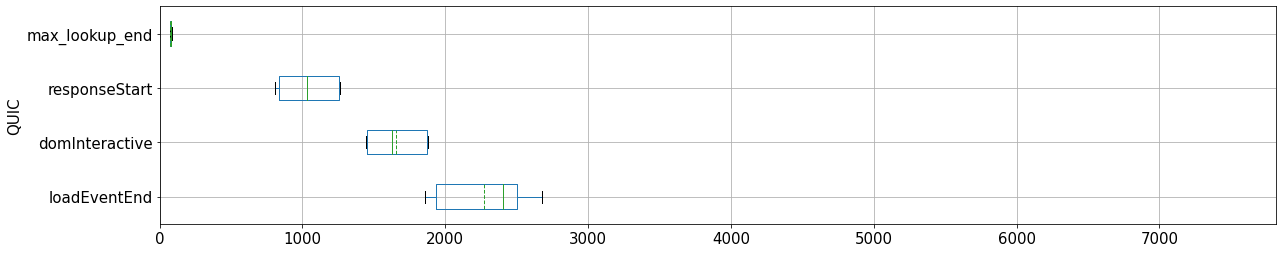

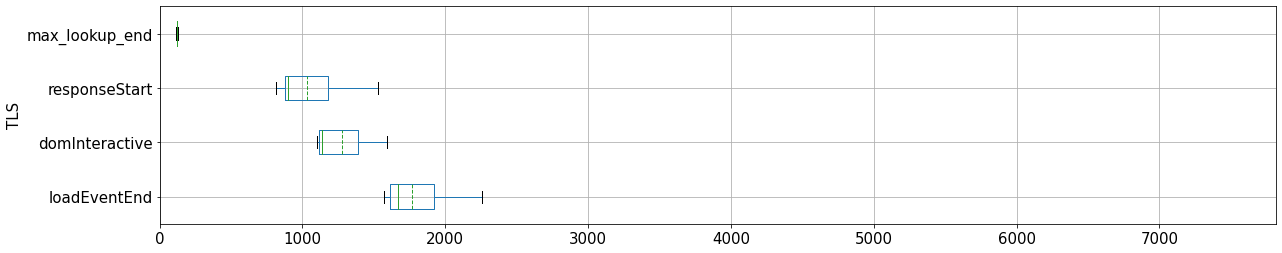

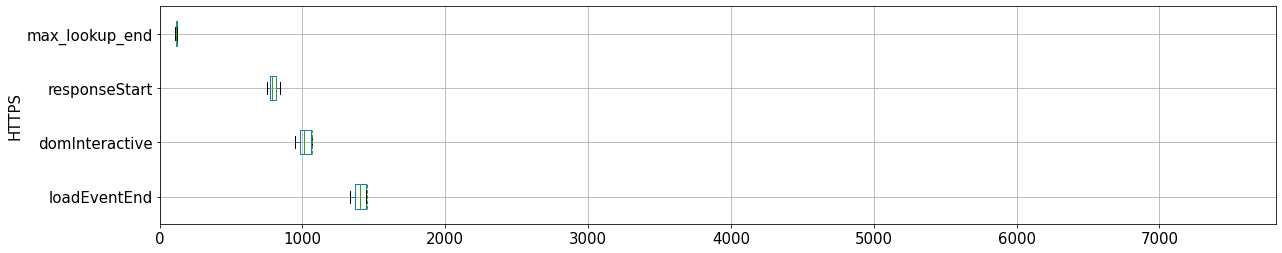

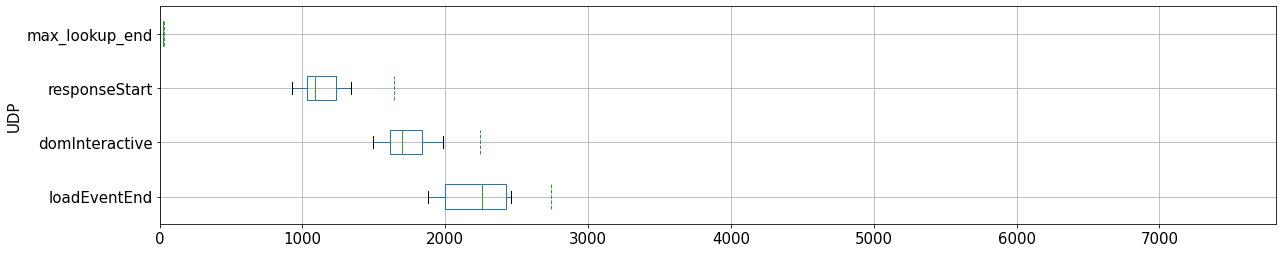

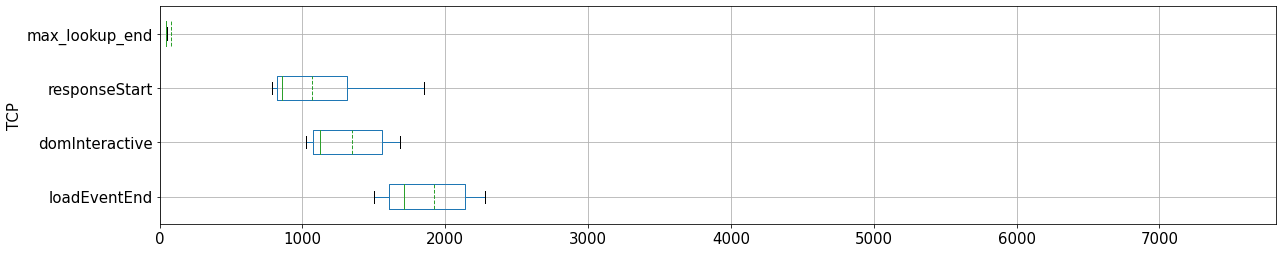

**netflix.net**

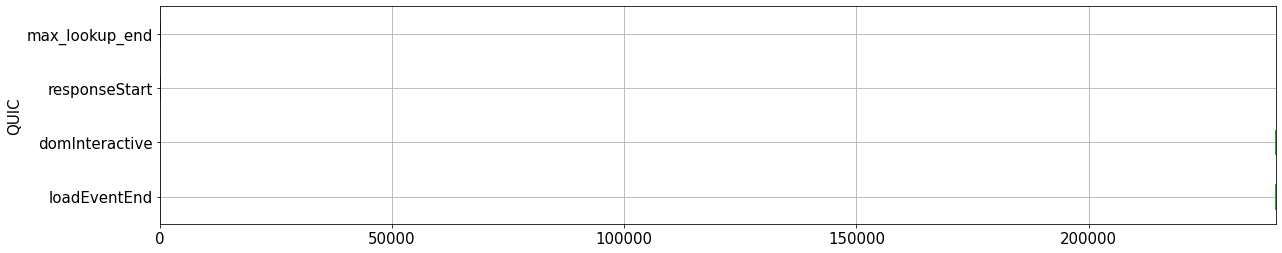

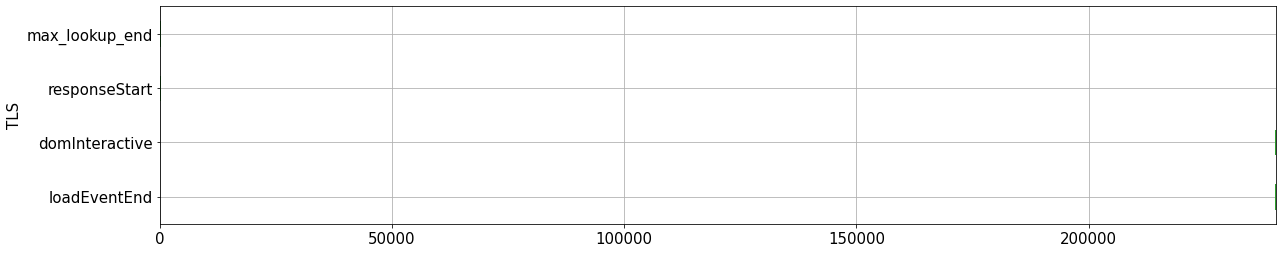

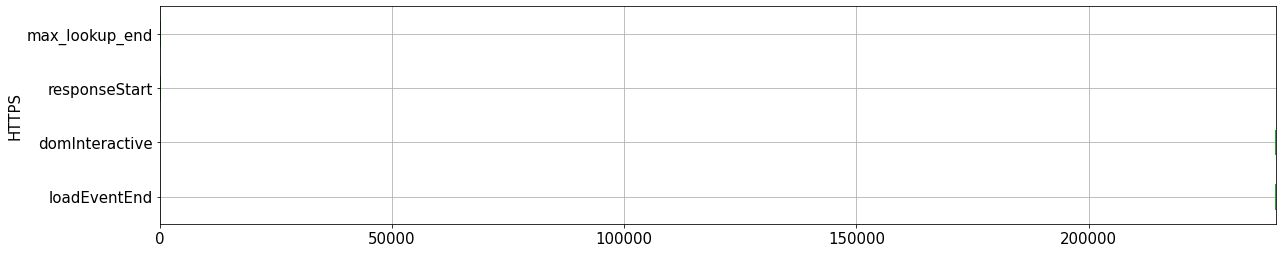

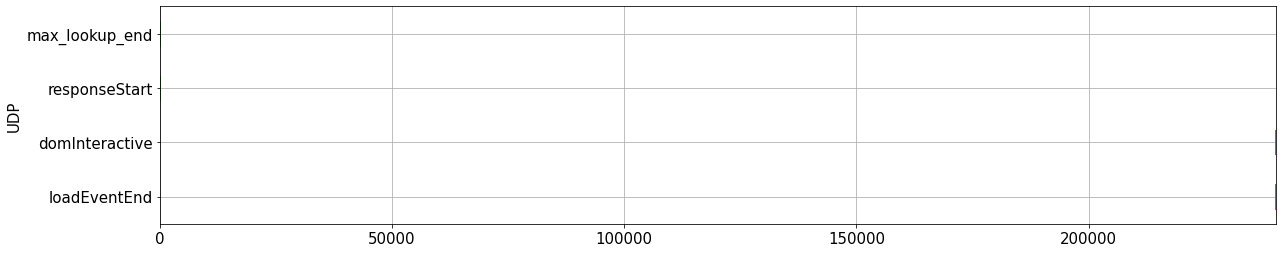

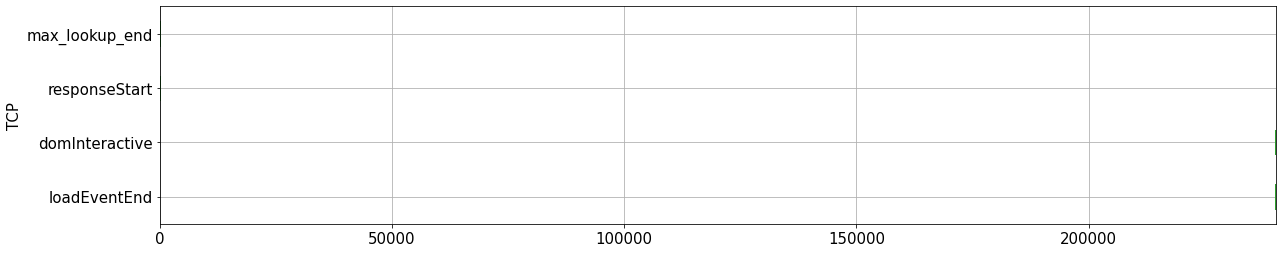

In [8]:
printmd(f"***pageload timeline***")

plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["font.size"] = 15

protocols = ['quic', 'tls', 'https', 'udp', 'tcp']
for domain in df['domain'].unique():
    printmd(f"**{domain}**")
    df_domain = df[df['domain'] == domain]
    for protocol in protocols:
        df_protocol = df_domain[df_domain['protocol'] == protocol]
        
        ax = df_protocol.boxplot(column=['loadEventEnd', 'domInteractive', 'responseStart', 'max_lookup_end'], vert=False, sym = "", meanline = True, showmeans = True)
        ax.set_ylabel(protocol.upper())
        ax.set_xlim(0, df_domain['loadEventEnd'].max())
        plt.show()

***MIN and MAX lookup times***

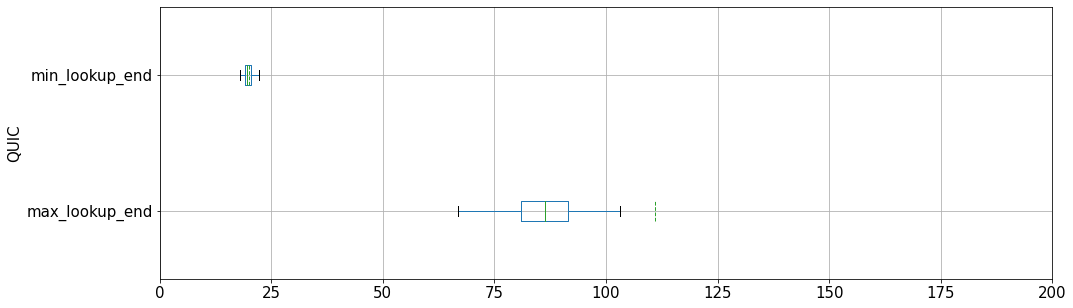

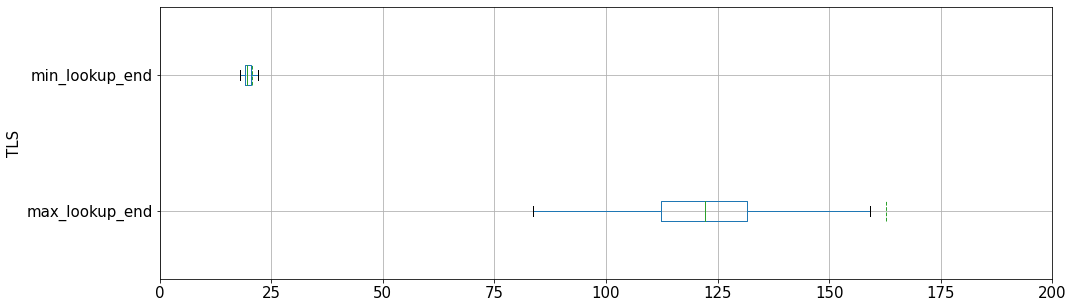

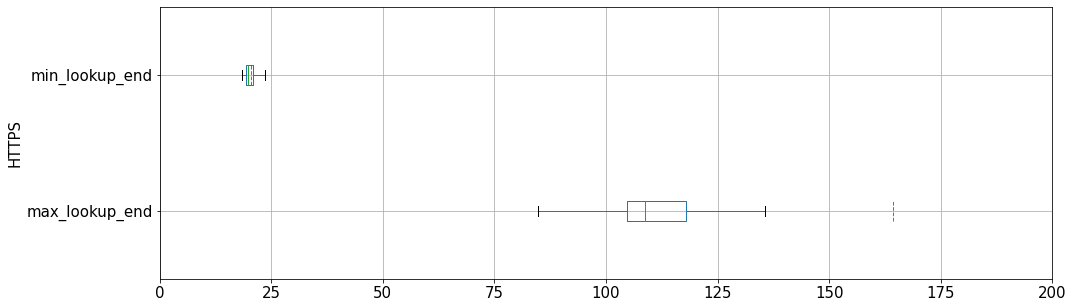

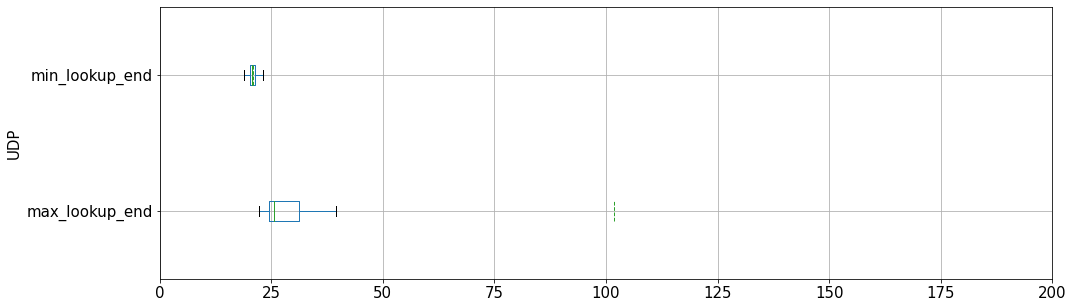

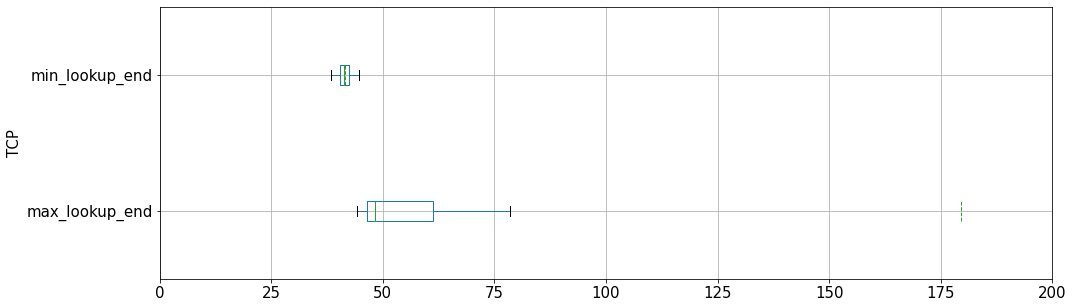

In [15]:
printmd(f"***MIN and MAX lookup times***")

plt.rcParams["figure.figsize"] = (16,5)
plt.rcParams["font.size"] = 15

protocols = ['quic', 'tls', 'https', 'udp', 'tcp']
for protocol in protocols:
    df_protocol = df[df['protocol'] == protocol]

    ax = df_protocol.boxplot(column=['max_lookup_end', 'min_lookup_end'], vert=False, sym = "", meanline = True, showmeans = True)
    ax.set_ylabel(protocol.upper())
    ax.set_xlim(0, 200)
    plt.show()